### All Visualizations for FSQ Data, FSQ Deduplicated Analysis, Validations, and Demographic Regressions

In [35]:
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas import sjoin

import re
import unicodedata
from collections import Counter

import networkx as nx
from geopy.distance import geodesic

# !pip install rapidfuzz
from rapidfuzz import process,fuzz
from rapidfuzz.fuzz import partial_ratio
from shapely.geometry import Point

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr

import contextily as ctx
from shapely import wkt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors


import random
import colorsys
import sys
import os

sys.path.append(os.path.abspath('./deduplication'))

from geohash_utils import assign_geohashes, get_neighboring_geohashes
from name_utils import NYC_BLACKLIST, remove_common_words, clean_name, choose_common_name_from_group
from processor import deduplicate
from other_utils import filter_by_zcta, extract_top_category, save_results_to_gdf, calculate_metrics, visualize_metrics, convert_fsq_csv_to_gdf

### FSQ POI PLOTS

In [ ]:
def plot_fsq_data(fsq_gdf):
    """ 
    Plots the provided FSQ GeoDataFrame POIs in [fsq_gdf] on a map.
    """
    fig, ax = plt.subplots(figsize=(12, 12))
    fsq_gdf = fsq_gdf.to_crs(epsg=4326)
    fsq_gdf = fsq_gdf.to_crs(epsg=3857)
    fsq_gdf.plot(ax = ax, color='#000080', edgecolor='white', alpha = 0.7, label='POIs', markersize = 10)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels)

    ax.legend()
    ax.set_title("POI Map")
    plt.tight_layout()
    plt.show()

def get_distinct_colors(n, seed = 42):
    """
    Generate `n` visually distinct RGB hex colors using evenly spaced HSL hues.
    Avoids similar-looking colors.
    """
    random.seed(seed)
    hues = [(i / n) for i in range(n)]
    random.shuffle(hues)  # Avoid close neighbors

    colors = []
    for h in hues:
        rgb = colorsys.hls_to_rgb(h, 0.6, 0.7)  # H, L, S
        hex_color = '#{:02x}{:02x}{:02x}'.format(
            int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255)
        )
        colors.append(hex_color)
    return colors
    # return [mcolors.to_hex(mcolors.hsv_to_rgb((i / (n-3), 0.7, 0.9))) for i in range(n)]

def plot_duplicate_groups(fsq_labeled_gdf):
    """ 
    Plots duplicated groups of POIs in [fsq_labeled_gdf] on a map.
    Prints out the names of POIs in duplicate groups to console.

    Parameters:
        fsq_labeled_gdf (GeoDataFrame): FSQ dataset that has been ran through the deduplication pipeline, and
        has additional columns 'isdup' and 'resolved_fsq_id' to mark duplicates and their groups
    """
    dups = fsq_labeled_gdf[fsq_labeled_gdf['isdup'] == True].sort_values('name')
    groups = dups.groupby("resolved_fsq_id")[['name']].agg(lambda x: ", ".join(sorted(x))).reset_index()
    for resolved_id in groups['resolved_fsq_id'].unique():
        group_rows = groups[groups['resolved_fsq_id'] == resolved_id]
        print("Group: ")
        for _, row in group_rows.iterrows():
            print(row['name'])
        print("\n")

    gdf = fsq_labeled_gdf.copy().to_crs(epsg=4326)  # Ensure CRS is WGS84 for plotting
    fig, ax = plt.subplots(figsize=(12, 12))
    # Step 1: Add numeric IDs for labeling
    gdf = gdf.reset_index(drop=True)
    gdf['plot_id'] = gdf.index + 1  # Start labels from 1

    # Convert to Web Mercator (EPSG:3857) for tile overlay
    if gdf.crs != 'EPSG:3857':
        gdf = gdf.to_crs(epsg=3857)

    # Prepare GeoDataFrames
    # Non-duplicate POIs
    # non_dup_rows = gdf[gdf['isdup'] == False]
    # non_dup_rows.plot(ax=ax, color='black', label='non-dups', alpha=0.7)

    # for _, row in non_dup_rows.iterrows():
    #     ax.scatter(row.geometry.x, row.geometry.y, color='black', s=30, alpha=0.8, label=None)
        # ax.text(
        #     row.geometry.x + 1.5,
        #     row.geometry.y,
        #     f"{row['name'][:10]}",
        #     fontsize=8,
        #     color='black',
        #     alpha=0.8,
        #     ha='left',
        #     fontweight='bold'
        # )     

    resolved_ids = gdf[gdf['isdup'] == True]['resolved_fsq_id'].unique()
    print("# of groups: " + str(len(resolved_ids)))
    distinct_colors = get_distinct_colors(len(resolved_ids), seed = 123)
    color_map = {rid: distinct_colors[i] for i, rid in enumerate(resolved_ids)}

    for id in resolved_ids:
        group = gdf[gdf['resolved_fsq_id'] == id]
        kept = group[group['resolved_fsq_id'] == id]
        dropped = group[group['resolved_fsq_id'] != id]
        rows_in_group = gdf[gdf['resolved_fsq_id'] == id]

        id_color = color_map[id]
        # Spatial spread
        coords = rows_in_group[['latitude', 'longitude']].values
        if len(coords) > 2:
        #     centroid = group.geometry.unary_union.centroid
        #     centroid_coords = (centroid.y, centroid.x)
        #     ax.scatter(centroid.x, centroid.y, color='black', s=40, alpha = 0.7)

        # Plot dropped duplicates in distinct color
            space = 0
            for _, row in group.iterrows():    
                ax.scatter(row.geometry.x, row.geometry.y, color=id_color, s=30, alpha=0.8)
                # ax.text(
                #     row.geometry.x,
                #     row.geometry.y + space,
                #     f"{row['name'][:30]}",
                #     fontsize=8,
                #     color=id_color,
                #     alpha=0.9,
                #     ha='left',
                #     fontweight='bold'
                # )   
            if len(coords) < 10:
                space += 30

    # Expand the view box
    xmin, ymin, xmax, ymax = gdf.total_bounds
    xpad = (xmax - xmin) * 0.1  # 20% padding
    ypad = (ymax - ymin) * 0.1

    ax.set_xlim(xmin - xpad, xmax + xpad)
    ax.set_ylim(ymin - ypad, ymax + ypad)
    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels)
    # Build side label list as one string
    # label_lines = [f"{int(row.plot_id)}. {row.name}" for _, row in gdf.sort_values('plot_id').iterrows()]
    # label_text = "\n".join(label_lines)

    # # Add to side of figure (outside axes area)
    # plt.figtext(
    #     0.92, 0.5, label_text,
    #     ha='left', va='center',
    #     fontsize=9, color='black',
    #     linespacing=1.4,
    #     wrap=True
    # )

    ax.legend()
    ax.set_title("Duplicate POI Resolution Map")
    plt.tight_layout()
    plt.show()


Example Usage

In [ ]:
 # ri_gdf = convert_fsq_csv_to_gdf('/share/garg/accessgaps2024/fsq_dedup_pipeline/results/ri_lbled_pois')
# MIN_LAT = 41.146
# MAX_LAT = 42.018
# MIN_LON = -71.882
# MAX_LON = -71.120
# ri_gdf = ri_gdf[
#     (ri_gdf['latitude'] >= MIN_LAT) & (ri_gdf['latitude'] <= MAX_LAT) &
#     (ri_gdf['longitude'] >= MIN_LON) & (ri_gdf['longitude'] <= MAX_LON)
# ]

# plot_fsq_data(ri_gdf)
# ----- OR ------
# plot_duplicate_groups(ri_gdf)

### Plotting Change in POIs Removed by Deduplication, Per Zip

In [ ]:
def plot_pois_removed(og_gdf, dedup_gdf, lbl_gdf, tracts):
    """ 
    Plots three side-by-side maps showing:
    1) Percent of POIs removed per census tract, and another centered at average
    2) Raw changes in POI counts between OG and Deduplicated FSQ datasets per census tract, and another centered at average
    3) Percent of POI shares removed per census tract, and another centered at average

    Parameters:
        og_gdf (GeoDataFrame): Original FSQ dataset before deduplication
        dedup_gdf (GeoDataFrame): Deduplicated FSQ dataset after running through deduplication
        lbl_gdf (GeoDataFrame): Labeled FSQ dataset after running through deduplication and manual labeling
        tracts (GeoDataFrame): Census tracts GeoDataFrame for the area of interest. Use pygris to obtain tracts for a state/region.
    """
    og_merge_gdf = og_gdf.to_crs(tracts.crs)
    dedup_merge_gdf = dedup_gdf.to_crs(tracts.crs)
    lbl_merge_gdf = lbl_gdf.to_crs(tracts.crs)
    og_merge = og_merge_gdf.sjoin(tracts, how = 'inner', predicate = 'within')
    dedup_merge = dedup_merge_gdf.sjoin(tracts, how = 'inner', predicate = 'within')
    lbl_merge = lbl_merge_gdf.sjoin(tracts, how = 'inner', predicate = 'within')
    print(str(len(og_merge)) + ' original POIs in NYC tracts')
    print(str(len(lbl_merge)) + ' labled OG POIs in NYC tracts')
    print(str(len(dedup_merge)) + ' dedup POIs in NYC tracts')

    geoids_to_plot = []
    geoid_percs = []
    percents = []
    for geoid in og_merge['GEOID'].unique():
        # print(geoid)
        geoid_og_counts = len(og_merge[og_merge['GEOID'] == geoid])
        geoid_dedup_counts = len(dedup_merge[dedup_merge['GEOID'] == geoid])
        perc_remove = 100 * ((geoid_og_counts - geoid_dedup_counts) / geoid_og_counts)
        removed = geoid_og_counts - geoid_dedup_counts
        if geoid_og_counts > 5:
            percents.append(perc_remove)
            geoid_percs.append((geoid, perc_remove))
            geoids_to_plot.append(geoid)
        # if perc_remove > 0:
        #     print(f"  {geoid}: {geoid_og_counts} -> {geoid_dedup_counts} ({perc_remove:.2f}% removed)")

    avg_percent_removed = sum(percents) / len(percents)
    print(f"Average percent of POIs removed: {avg_percent_removed:.2f}%")

    avg_stat = np.mean(percents)
    tracts_geoids = tracts[tracts['GEOID'].isin(geoids_to_plot)]
    geoid_perc_df = pd.DataFrame(geoid_percs, columns = ['GEOID', 'perc_removed'])
    tracts_with_perc = tracts_geoids.merge(geoid_perc_df, on = 'GEOID', how = 'inner')
    tracts_with_perc = tracts_with_perc.to_crs(epsg = 3857)
    # tracts_geoids = tracts_geoids.to_crs(epsg = 3857)

    # Define color scale limits centered at average
    vmin = min(tracts_with_perc['perc_removed'].min(), 2 * avg_stat - tracts_with_perc['perc_removed'].max())
    vmax = max(tracts_with_perc['perc_removed'].max(), 2 * avg_stat - tracts_with_perc['perc_removed'].min())

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12), constrained_layout=True)

    # Plot 1: Normal (Reds)
    tracts_with_perc.plot(
        ax=ax1,
        column='perc_removed',
        cmap='Reds',
        legend=True,
        edgecolor='black',
        missing_kwds={"color": "lightgrey", "label": "No POIs"}
    )
    ax1.set_title("Raw Percent of POIs Removed per Census Tract", fontsize=14)
    ax1.axis('off')

    # Plot 2: Centered diverging colormap
    tracts_with_perc.plot(
        ax=ax2,
        column='perc_removed',
        cmap='coolwarm',
        legend=True,
        edgecolor='black',
        vmin=vmin,
        vmax=vmax,
        missing_kwds={"color": "lightgrey", "label": "No POIs"}
    )
    # ax2.axhline(y=avg_percent_removed, color='black', linestyle='--', linewidth=1, alpha=0.6)
    ax2.set_title(f"Centered at Avg ({avg_stat:.1f}%)", fontsize=14)
    ax2.axis('off')
    # Before adding basemap
    ax1.set_xlim(tracts_with_perc.total_bounds[[0, 2]])
    ax1.set_ylim(tracts_with_perc.total_bounds[[1, 3]])
    ax2.set_xlim(tracts_with_perc.total_bounds[[0, 2]])
    ax2.set_ylim(tracts_with_perc.total_bounds[[1, 3]])

    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.PositronNoLabels, crs='EPSG:3857')
    ctx.add_basemap(ax2, source=ctx.providers.CartoDB.PositronNoLabels, crs='EPSG:3857')

    plt.suptitle("Deduplication Impact on Percentage of POIs Removed (For Each  Census Tract with >5 OG Theater POIs)", fontsize=16)
    plt.show()

    geoid_percs = []
    counts = []
    for geoid in og_merge['GEOID'].unique():
        # print(geoid)
        og_rows = og_merge[og_merge['GEOID'] == geoid]
        dedup_rows = dedup_merge[dedup_merge['GEOID'] == geoid]
        geoid_og_counts = len(og_rows)
        geoid_dedup_counts = len(dedup_rows)
        perc_remove = 100 * ((geoid_og_counts - geoid_dedup_counts) / geoid_og_counts)
        removed = geoid_og_counts - geoid_dedup_counts
        # ratio = np.log1p(removed) - np.log1p(geoid_dedup_counts)  # log(1 + removed) - log(1 + kept)
        # geoid_percs.append((geoid, ratio))

        # percents.append(ratio)
        # percents.append(removed)
        # geoid_percs.append((geoid, removed))
        # if geoid_og_counts > 3:
        counts.append(removed)
        geoid_percs.append((geoid, removed))
        # if perc_remove > 0:
        #     print(f"  {geoid}: {geoid_og_counts} -> {geoid_dedup_counts} ({perc_remove:.2f}% removed)")

    avg_counts = sum(counts) / len(counts)
    print(f"Average counts of POI removed: {avg_percent_removed:.2f}%")

    avg_stat = np.mean(percents)
    tracts_geoids = tracts[tracts['GEOID'].isin(og_merge['GEOID'].to_list())]
    geoid_perc_df = pd.DataFrame(geoid_percs, columns = ['GEOID', 'perc_removed'])
    tracts_with_perc = tracts_geoids.merge(geoid_perc_df, on = 'GEOID', how = 'inner')

    tracts_with_perc = tracts_with_perc.to_crs(epsg = 3857)

    # Define color scale limits centered at average
    vmin = min(tracts_with_perc['perc_removed'].min(), 2 * avg_stat - tracts_with_perc['perc_removed'].max())
    vmax = max(tracts_with_perc['perc_removed'].max(), 2 * avg_stat - tracts_with_perc['perc_removed'].min())

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12), constrained_layout=True)

    # Plot 1: Normal (Reds)
    tracts_with_perc.plot(
        ax=ax1,
        column='perc_removed',
        cmap='Reds',
        legend=True,
        edgecolor='black',
        missing_kwds={"color": "lightgrey", "label": "No POIs"}
    )
    ax1.set_title("Raw # of POIs Removed per Census Tract", fontsize=14)
    ax1.axis('off')

    # Plot 2: Centered diverging colormap
    tracts_with_perc.plot(
        ax=ax2,
        column='perc_removed',
        cmap='coolwarm',
        legend=True,
        edgecolor='black',
        vmin=vmin,
        vmax=vmax,
        missing_kwds={"color": "lightgrey", "label": "No POIs"}
    )
    # ax2.axhline(y=avg_percent_removed, color='black', linestyle='--', linewidth=1, alpha=0.6)
    ax2.set_title(f"Centered at Avg ({avg_stat:.1f}%)", fontsize=14)
    ax2.axis('off')


    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.PositronNoLabels)
    ctx.add_basemap(ax2, source=ctx.providers.CartoDB.PositronNoLabels)


    plt.suptitle("Deduplication Impact on POI Counts (Per Census Tract)", fontsize=16)
    plt.show()

    geoids_to_plot = []
    geoid_shares = []
    shares = []
    for geoid in og_merge['GEOID'].unique():
        # print("geoid: " + str(geoid))
        og_rows = og_merge[og_merge['GEOID'] == geoid]
        dedup_rows = dedup_merge[dedup_merge['GEOID'] == geoid]
        lbled_rows = lbl_merge[lbl_merge['GEOID'] == geoid]

        # print("len(og_rows): " + str(len(og_rows)))
        # print("len(dedup_rows): " + str(len(dedup_rows)))
        # print("len(lbled_rows): " + str(len(lbled_rows)))
        valid_ids = lbled_rows['resolved_fsq_id'].dropna().unique()
        num_kept = len(valid_ids)
        # print("num kept: " + str(num_kept))
        geoid_dedup_counts = len(dedup_rows)
        share_remove = 100 * (num_kept / geoid_dedup_counts)
        # print("share_remove: " + str(share_remove))
        if len(dedup_rows) > 3 and num_kept != geoid_dedup_counts:
            geoids_to_plot.append(geoid)
            shares.append(share_remove)
            geoid_shares.append((geoid, share_remove))
        # if perc_remove > 0:
        #     print(f"  {geoid}: {geoid_og_counts} -> {geoid_dedup_counts} ({perc_remove:.2f}% removed)")

    avg_share_removed = sum(shares) / len(shares)
    print(f"Average percent of POIs that were kept in a dup group, out of all deduplicated POIs: {avg_share_removed:.2f}%")

    tracts_geoids = tracts[tracts['GEOID'].isin(og_merge['GEOID'].to_list())]
    geoid_perc_df = pd.DataFrame(geoid_shares, columns = ['GEOID', 'share_removed'])
    tracts_with_perc = tracts_geoids.merge(geoid_perc_df, on = 'GEOID', how = 'inner')
    tracts_with_perc = tracts_with_perc.to_crs(epsg = 3857)

    # Define color scale limits centered at average
    vmin = min(tracts_with_perc['share_removed'].min(), 2 * avg_stat - tracts_with_perc['share_removed'].max())
    vmax = max(tracts_with_perc['share_removed'].max(), 2 * avg_stat - tracts_with_perc['share_removed'].min())

    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12), constrained_layout=True)

    # Plot 1: Normal (Reds)
    tracts_with_perc.plot(
        ax=ax1,
        column='share_removed',
        cmap='Reds',
        legend=True,
        edgecolor='black',
        missing_kwds={"color": "lightgrey", "label": "No POIs"}
    )
    ax1.set_title("% of POI Shares Removed per Census Tract", fontsize=14)
    ax1.axis('off')

    # Plot 2: Centered diverging colormap
    tracts_with_perc.plot(
        ax=ax2,
        column='share_removed',
        cmap='coolwarm',
        legend=True,
        edgecolor='black',
        vmin=vmin,
        vmax=vmax,
        missing_kwds={"color": "lightgrey", "label": "No POIs"}
    )
    # ax2.axhline(y=avg_percent_removed, color='black', linestyle='--', linewidth=1, alpha=0.6)
    ax2.set_title(f"Centered at Avg ({avg_share_removed:.1f}%)", fontsize=14)
    ax2.axis('off')

    ctx.add_basemap(ax1, source=ctx.providers.CartoDB.PositronNoLabels)
    ctx.add_basemap(ax2, source=ctx.providers.CartoDB.PositronNoLabels)

    plt.suptitle("Deduplication Impact on POI Duplicate Shares (Per Census Tract)", fontsize=16)
    plt.show()

# Example usage:
# og_gdf = convert_fsq_csv_to_gdf('/share/garg/accessgaps2024/fsq_dedup_pipeline/data/fsq_data/nyc_theater_fsq_pois')
# dedup_gdf = convert_fsq_csv_to_gdf('/share/garg/accessgaps2024/fsq_dedup_pipeline/results/nyc_theater_dedup_pois')
# lbl_gdf = convert_fsq_csv_to_gdf('/share/garg/accessgaps2024/fsq_dedup_pipeline/results/nyc_theater_lbled_pois')

# # %pip install pygris
# import pygris
# ny_tracts = pygris.tracts(state = "NY")
# print(ny_tracts.head())
# plot_pois_removed(og_gdf, dedup_gdf, lbl_gdf, ny_tracts)

In [ ]:
# nyc_gdf = convert_fsq_csv_to_gdf("/share/garg/wildfires/data/nyc_places.parquet")
# is_theater = nyc_gdf['fsq_category_labels'].apply(lambda x: ((any(x_cat in i for i in x for x_cat in ['Indie Theater', 'College Theater'])) or (all(x_cat in i for i in x for x_cat in ['Performing Arts Venue', 'Theater']))) if isinstance(x, np.ndarray) else False)
# theaters = nyc_gdf[is_theater]
# theaters.to_csv("/share/garg/accessgaps2024/fsq_dedup_pipeline/data/fsq_data/nyc_theater_fsq_pois")
# theaters_dedup, theaters_lbled, theater_metrics = await deduplicate(theaters, max_distance = 100, name_similarity_threshold = 90, precision = 7, file_name = '/share/garg/accessgaps2024/fsq_dedup_pipeline/results/nyc_theater_metrics')
# theaters_dedup.to_csv('/share/garg/accessgaps2024/fsq_dedup_pipeline/results/nyc_theater_dedup_pois')
# theaters_lbled.to_csv('/share/garg/accessgaps2024/fsq_dedup_pipeline/results/nyc_theater_lbled_pois')

,fsq_place_id,name,latitude,longitude,address,locality,region,postcode,admin_region,post_town,...,twitter,fsq_category_ids,fsq_category_labels,placemaker_url,unresolved_flags,geom,bbox,dt,geom_1,geometry
82,4c14308da9c220a19036579d,Rockaway Theatre Company,40.564450,-73.884903,"Building T-4, Ft Tilden",Breezy Point,NY,11697,None,None,...,None,[4bf58dd8d48988d137941735],[Arts and Entertainment > Performing Arts Venu...,https://foursquare.com/placemakers/review-plac...,None,b'\x01\x01\x00\x00\x004\xdb\x9c@\xa2xR\xc0\x99...,"{'xmin': -73.88490310018534, 'ymin': 40.564449...",2025-06-10,b'\x01\x06\x00\x00\x00\x03\x00\x00\x00\x01\x03...,POINT (-73.8849 40.56445)
99,4c06eb712e80a59390e474f9,Post Theatre at Ft. Tilden,40.567393,-73.886168,"Building T-4, Ft. Tilden",Breezy Point,NY,11697,None,None,...,None,[4bf58dd8d48988d137941735],[Arts and Entertainment > Performing Arts Venu...,https://foursquare.com/placemakers/review-plac...,None,b'\x01\x01\x00\x00\x00\x01Q\x90\xf9\xb6xR\xc0\...,"{'xmin': -73.88616789906884, 'ymin': 40.567392...",2025-06-10,b'\x01\x06\x00\x00\x00\x03\x00\x00\x00\x01\x03...,POINT (-73.88617 40.56739)
787,539c75db498eae48dd8f3d42,Game Show Block Party Studio @ Mill Basin,40.617325,-73.910960,Mill Basin,Brooklyn,NY,None,None,None,...,None,[4bf58dd8d48988d137941735],[Arts and Entertainment > Performing Arts Venu...,https://foursquare.com/placemakers/review-plac...,None,b'\x01\x01\x00\x00\x00\xb5\xfd++MzR\xc0i\x00o\...,"{'xmin': -73.91096, 'ymin': 40.617325, 'xmax':...",2025-06-10,b'\x01\x06\x00\x00\x00\x03\x00\x00\x00\x01\x03...,POINT (-73.91096 40.61732)
960,55045cbe498edf5e042fb840,Tv Studio Live,40.609127,-73.915604,None,Brooklyn,NY,None,None,None,...,None,[4bf58dd8d48988d135941735],[Arts and Entertainment > Performing Arts Venu...,https://foursquare.com/placemakers/review-plac...,None,b'\x01\x01\x00\x00\x00\x00\x00\x00@\x99zR\xc0\...,"{'xmin': -73.91560363769531, 'ymin': 40.609127...",2025-06-10,b'\x01\x06\x00\x00\x00\x03\x00\x00\x00\x01\x03...,POINT (-73.9156 40.60913)
3251,5136c04ce4b02318b0554d7e,Cano's Juice Factory,40.610576,-73.931418,None,Brooklyn,NY,None,None,None,...,None,[4bf58dd8d48988d135941735],[Arts and Entertainment > Performing Arts Venu...,https://foursquare.com/placemakers/review-plac...,None,"b""\x01\x01\x00\x00\x00\x00\xfecY\x9c{R\xc0\xac...","{'xmin': -73.93141779675352, 'ymin': 40.610575...",2025-06-10,b'\x01\x06\x00\x00\x00\x03\x00\x00\x00\x01\x03...,POINT (-73.93142 40.61058)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673971,4f7733eee4b04368dc7a5184,The Up Broadway Theatre,40.848714,-73.938775,"Broadway, New York, NY",New York,NY,10023,None,None,...,None,[4bf58dd8d48988d137941735],[Arts and Entertainment > Performing Arts Venu...,https://foursquare.com/placemakers/review-plac...,None,b'\x01\x01\x00\x00\x00\xb8M0\xe3\x14|R\xc0\xf7...,"{'xmin': -73.93877486912868, 'ymin': 40.848713...",2025-06-10,b'\x01\x06\x00\x00\x00\x03\x00\x00\x00\x01\x03...,POINT (-73.93877 40.84871)
674075,51130e02e4b0fbce8fe9770b,The Americans,40.849267,-73.937191,Broadway,New York,NY,10033,None,None,...,None,[4bf58dd8d48988d137941735],[Arts and Entertainment > Performing Arts Venu...,https://foursquare.com/placemakers/review-plac...,None,b'\x01\x01\x00\x00\x00\xd6\xbb\xf6\xf0\xfa{R\x...,"{'xmin': -73.93719123931018, 'ymin': 40.849266...",2025-06-10,b'\x01\x06\x00\x00\x00\x03\x00\x00\x00\x01\x03...,POINT (-73.93719 40.84927)
674542,517b4c31e4b0b54669afcadd,Vouge Capital Of The Heights,40.848508,-73.939151,None,New York,NY,None,None,None,...,None,[4bf58dd8d48988d1ac941735],[Community and Government > Education > Colleg...,https://foursquare.com/placemakers/review-plac...,None,b'\x01\x01\x00\x00\x00]\xc0\xcb\x0c\x1b|R\xc0{...,"{'xmin': -73.939151, 'ymin': 40.848508, 'xmax'...",2025-06-10,b'\x01\x06\x00\x00\x00\x03\x00\x00\x00\x01\x03...,POINT (-73.93915 40.84851)
674876,4f63ba8ae4b098b3949cf721,Muay Thai At The Mecca,40.850632,-73.951524,None,None,None,None,None,None,...,Non

### Visualize Duplicate Group Metrics

Summary: 
            n_names  n_addresses  dominant_name_ratio  mean_name_similarity  \
count   2216.000000  2216.000000          2216.000000           2216.000000   
unique          NaN          NaN                  NaN                   NaN   
top             NaN          NaN                  NaN                   NaN   
freq            NaN          NaN                  NaN                   NaN   
mean       2.284296     1.268953             0.502309             78.860813   
std        2.162359     0.623724             0.158190             19.210861   
min        1.000000     0.000000             0.015625             19.230769   
25%        2.000000     1.000000             0.500000             64.695308   
50%        2.000000     1.000000             0.500000             80.406338   
75%        2.000000     2.000000             0.500000            100.000000   
max       64.000000     7.000000             1.000000            100.000000   

        mean_distance_m  max_distance_m  

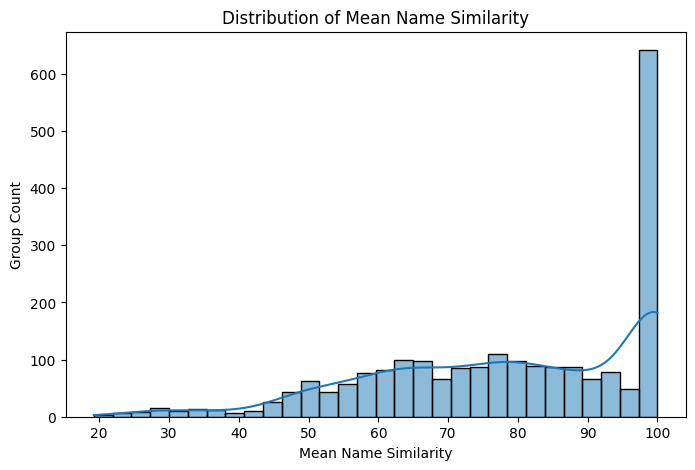

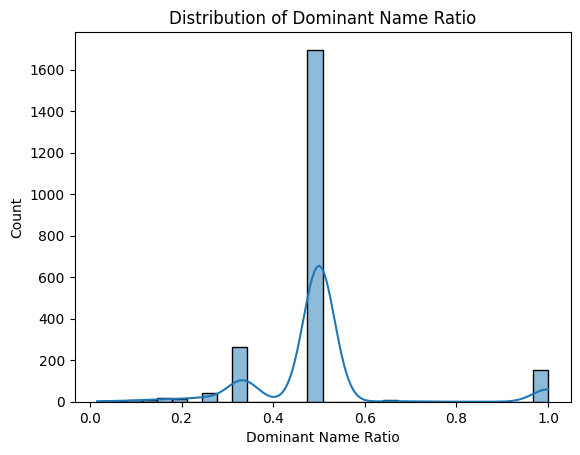

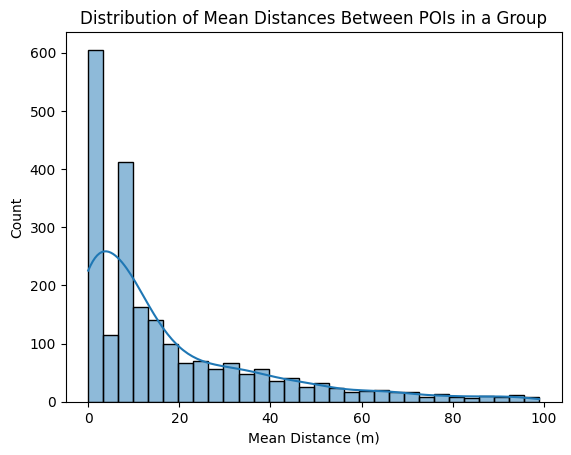

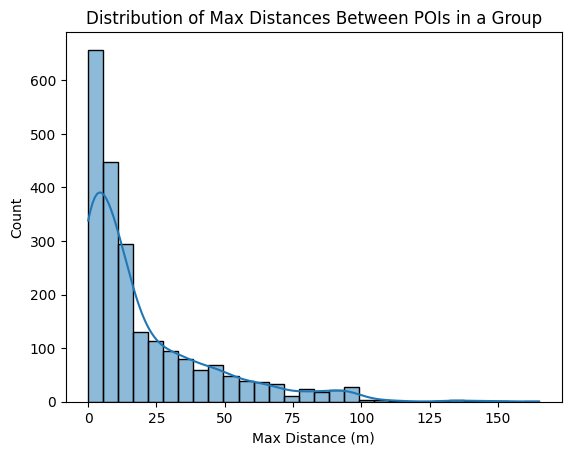

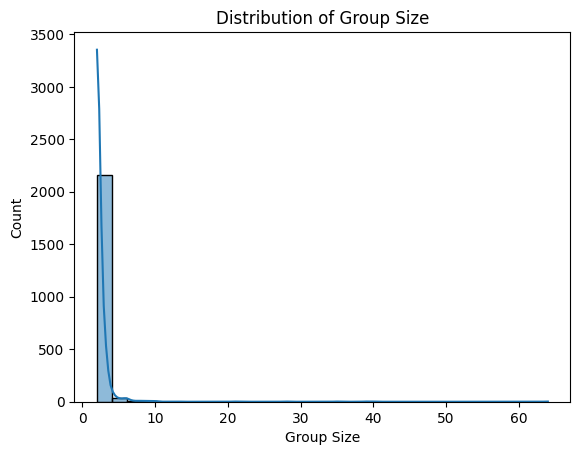

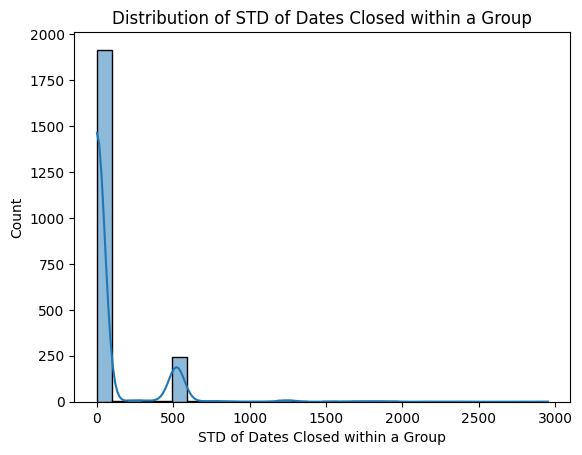

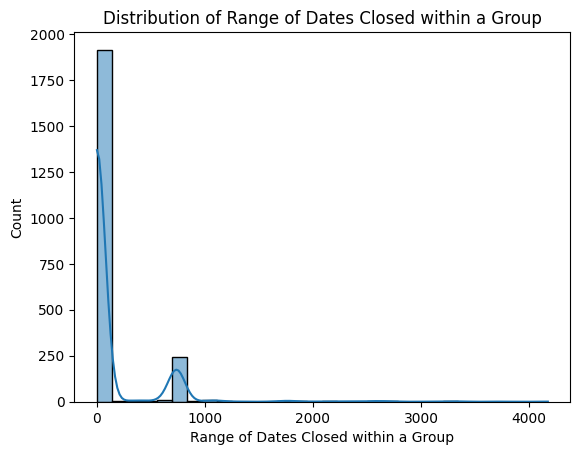

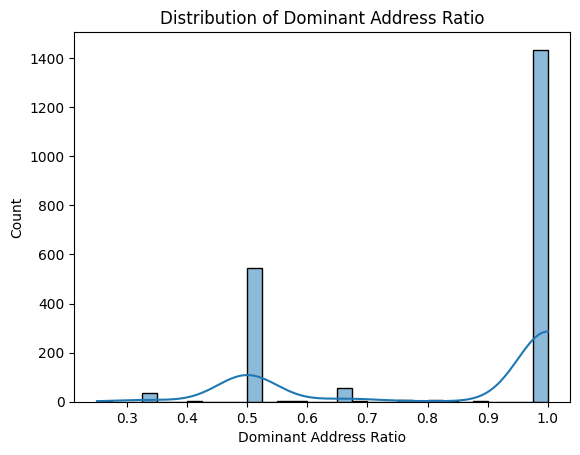

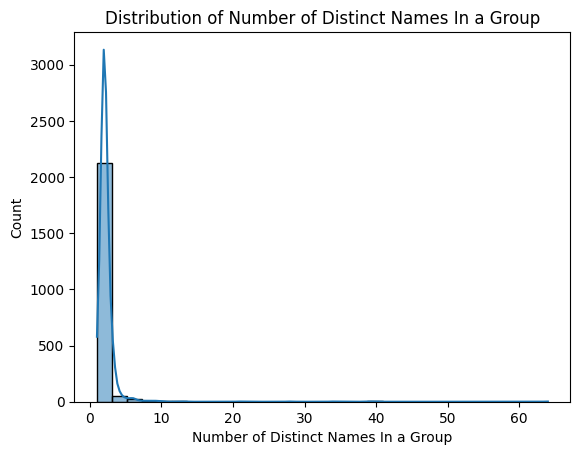

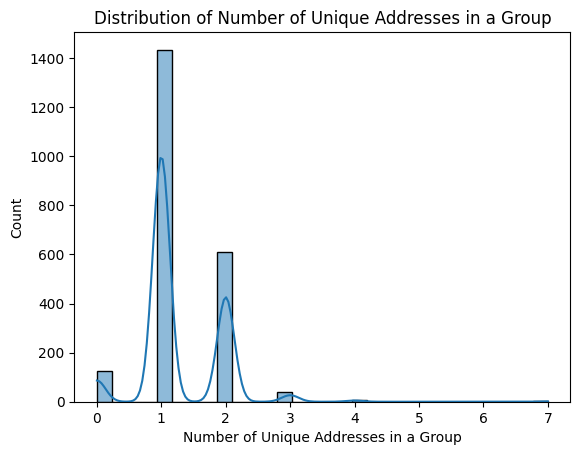

In [11]:
metrics_file_path = "/share/garg/accessgaps2024/fsq_dedup_pipeline/results/ri_metrics" # replace with your own
visualize_metrics(metrics_file_path)

### Demographics Info

In [12]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr
import numpy as np
from sklearn.preprocessing import StandardScaler

# change this list to the zips you want to process
zips_done = [10001, 10002, 10003, 10004, 10005, 10006, 10007, 10009, 10010, 10011, 10012, 10013, 
    10014, 10016, 10017, 10018, 10019, 10021, 10023, 10024, 10025, 10026, 10027, 
    10028, 10029, 10030, 10031, 10032, 10033, 10034, 10035, 10037, 10038, 10039, 
    10040, 10044, 10069, 10103, 10119, 10128, 10162, 10165, 10170, 10173, 10199, 10279, 
    10280, 10282, 10022, 10028, 10036, 10065, 10075]

pop = gpd.read_file('/share/garg/dogathon/d01_data/d02_demographics/ZCTA.gpkg')
pop_man = pop[pop['ZCTA'].isin(zips_done)]
pop_man['ZCTA'] = pop_man['ZCTA'].astype(str)
pop_man = pop_man.rename(columns = {'ZCTA': 'zip'})

/share/garg/conda_virtualenvs/wildfires/lib/python3.9/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Mappings (for Manhattan Only) and Helper Functions

In [ ]:
lander_naics_mapping = {
   "childcare" : [6111, 624110, 624410],
   "fire_stations" : [926610],
   "police_precincts" : [922120, 561612, 928110],
   "parks" : [712190, 721211, 712130],
   "waste_management" : [5621, 5622, 5629, 924110, 562998, 221320],
    "homeless_shelters" : [624221, 624230],
    "social_services" : [621112, 621330, 621420, 6222, 6232]
}

lander_fsq_mapping = {
   "childcare" : ["Child Care Service", "Elementary School", "Preschool", "Nursery School"],
   "fire_stations" : ["Fire Station"],
   "police_precincts" : ["Police Station"],
   "parks" : ["Park"],
   "waste_management" : ["Waste Management Service", "Water Treatment Service", "Recycling Facility"],
   "homeless_shelters" : ["Homeless Shelter", 'Public and Social Service', 'Government Building', 'Organization',
                         'Community Center', 'Housing Development', 'Rehabilitation Center', 'Shelter', 'Spiritual Center',
                         'Assisted Living', 'Charity'],
   "social_services" : ["Mental Health Services", "Addiction Treatment Center", "Domestic Abuse Treatment Center", "Rehabilitation Center"]
}

def convert_prefix_to_label(mapping):
    """ 
    Converts a mapping of labels to NAICS codes into a mapping of NAICS code prefixes (as strings) to labels.

    Parameters:
        mapping (dict): A dictionary where keys are labels and values are lists of NAICS codes
    """
    prefix_to_label = {}
    for label, codes in mapping.items():
        for c in codes:
            prefix_to_label[str(c)] = label
    return prefix_to_label

def assign_label(naics_str, mapping):
    """ 
    Used as a crosswalk between ZBP categories (NAICS codes) and Lander Report Categories.
    Assigns a label to a NAICS code based on the provided mapping of labels to NAICS codes.
    Returns None if no match for [naics_str] is found in [mapping]
    Parameters:
        naics_str (str): The NAICS code as a string
        mapping (dict): A dictionary where keys are labels and values are lists of NAICS codes
    """
    for code, label in convert_prefix_to_label(mapping).items():
        if naics_str.startswith(code):
            return label
    else:
        return None
  
def get_lander_category(x, mapping):
    """ 
    Used as a crosswalk between FSQ categories and Lander Report Categories.
    Returns the lander category (str) for a given list containing FSQ category labels [x], using the provided mappping.
    Parameters:
        x (str list): a FSQ Category Label for one POI, can contain more than 1 label
        mapping (dict): maps lander categories (as strings) to FSQ categories
    """
    for lander_cat, fsq_cat in mapping.items():
        for cat in fsq_cat:
            if any(cat.lower() in v.lower() for v in x):
               return lander_cat
    return None

def clean_naics(naics_str):
    """ 
    Extracts and returns the first 2-6 digits of [naics_str]. If no match is found 
    ([naics_str] does not contain any leading digits), then the empty string is returned.

    Parameters:
        naics_str (str): NAICS code of a ZBP establishment count, representing its category.
        The longer naics_str is, the more specific the category will be.
    """
    match = re.match(r'^(\d{2,6})', naics_str)
    return match.group(1) if match else ""

def filter_res_by_zips(res_data, zip_lst):
    """
    Helper method to generate_zbp_counts_per_zip_year_category.
    Filters ZBP data ([res_data]) to within the zips in [zip_lst].

    Parameters:
        res_data (DataFrame): ZBP data
        zip_lst (str list): list of zip codes (as strings) to filter the ZBP data in
    """
    def check_if_in_res(zip):
        s = str(zip)
        return True if any(s.startswith(suff) for suff in zip_lst) and len(s) == 5 else False
    return res_data[res_data['zip'].apply(check_if_in_res)]

def plot_CIs_covariates(CIs_df, crop_plots=True, ax=None, figsize=(6, 6),
                        covariate_names=None, show=True, ylabel_size=12,
                        xlabel_size=12,
                        color_CIs_by_significance=True, fill_between=False, horizontal_lines=True):
    """ 
    Plots graphs of Confidence Intervals for Each Demographic in [covariate_names]. 
    When a CI crosses the center at 0, it means that the residuals are not significant for that demographic predictor, 
    and thus there is negligible bias.
    When a CI is to the left of the center, it means that the ZBP and FSQ residuals are negatively correlated.
    This indicates that FSQ is undercounting the count/share/count_per_capita of POIs when only looking at that demographic.
    When a CI is to the right of the center, the ZBP and FSQ residuals are positively correlated.
    This suggests that FSQ is overcounting the count/share/count_per_capita of POIs for that demographic.

    Parameters:
        CIs_df (DataFrame): df of residuals univariately regressed against each demographic, their estimate, lower bound, and upper bound.
                            Must contain columns for each of [covariate_names], 'Estimate', 'Upper bound', and 'Lower bound'.
                            Refer to def get_univariate_ci_df(X_df, y_series).
        covariate_names (str list): a list of demographics to regress the residuals on
    """
    
    if ax is None: fig, ax = plt.subplots(figsize=figsize)
    
    CIs_df = CIs_df.replace({'-':np.nan}).dropna()
    if covariate_names is None: covariate_names = CIs_df.index.values
    
    estimates = CIs_df.loc[covariate_names, 'Estimate'].values
    UB = CIs_df.loc[covariate_names, 'Upper bound'].values
    LB = CIs_df.loc[covariate_names, 'Lower bound'].values
    CIs = np.vstack([estimates-LB, UB-estimates])

    #Collect colors:
    if color_CIs_by_significance:
        colors = ['red' if ub < 0 else ('blue' if lb > 0 else 'grey')
                 for ub, lb in list(zip(UB, LB))]
    else:
        colors = ['black']*len(estimates)

    #Plot:
    for estimate, name, CI, color in zip(estimates[::-1],
                                         covariate_names[::-1],
                                         CIs[::, ::-1].T,
                                         colors[::-1]):
        _ = ax.errorbar(x=estimate,
                        y=name,
                        xerr=CI.reshape(2,1),
                        ecolor=color,
                        capsize=5,
                        linestyle='None',
                        linewidth=1.5,
                        marker="D",
                        markersize=5,
                        mfc=color,
                        mec=color)

    ax.tick_params(axis='y', labelsize=ylabel_size)
    ax.tick_params(axis='x', labelsize=xlabel_size)
    #Grids:
    xlim = ax.get_xlim()
    _ = ax.axvline(0, linestyle='--', color='black', alpha=0.75, zorder=-1, linewidth=1.)
    #Fill between:
    if fill_between:
        #Home ownership:
        _ = ax.fill_between(np.linspace(xlim[0], xlim[1], 1000, endpoint=True), -0.5, 1.5, alpha=.4, color='lightgrey', linewidth=0)
        #Education:
        _ = ax.fill_between(np.linspace(xlim[0], xlim[1], 1000, endpoint=True), 6.5, 8.5, alpha=.4, color='lightgrey', linewidth=0)
        #Demographics:
        _ = ax.fill_between(np.linspace(xlim[0], xlim[1], 1000, endpoint=True), 10.5, 14.5, alpha=.4, color='lightgrey', linewidth=0)
    if horizontal_lines:
        for y, c in enumerate(colors[::-1]):
            _ = ax.hlines(y=y, xmin=-3, xmax=3, linestyle='--', linewidth=0.5, alpha=0.5, color='grey')
    _ = ax.set_xlim(xlim)
    _ = ax.set_ylim(-0.5, len(estimates)-0.5)
            
    if show: plt.show()
        
    return ax

def get_ci_df(X, y, covariate_names):
    """ 
    Finds the best-fit multivariate regression of ALL demographics in X on y,
    and returns a DataFrame storing the confidence intervals for all demographics 
    (where the index is the covariate_names).
    """
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    estimates = model.params[1:]  # skip intercept
    conf = model.conf_int().ilox-c[1:]  # skip intercept
    return pd.DataFrame({
        "Estimate": estimates.values,
        "Lower bound": conf[0].values,
        "Upper bound": conf[1].values
    }, index=covariate_names)


def get_univariate_ci_df(X_df, y_series):
    """ 
    Finds the best-fit univariate regression of EACH demographic predictor in X on y.
    Stores and returns the CI results in a DataFrame, where the index is the predictor name columns.
    """
    ci_list = []
    for col in X_df.columns:
        x = sm.add_constant(X_df[[col]])
        model = sm.OLS(y_series, x).fit()
        est = model.params[col]
        conf = model.conf_int().loc[col]
        ci_list.append({
            "Estimate": est,
            "Lower bound": conf[0],
            "Upper bound": conf[1]
        })
    return pd.DataFrame(ci_list, index=X_df.columns)


def compute_overlap_stats(fsq_proj, ground_truth_proj, buffer_dist = 100):
    """ 
    Helper function for produce_plot_all_counts_gt_fsq.
    Prints overlap statistics between FSQ and Ground Truth GeoDataFrames, 
    with a buffer distance between any overlap match.

    Parameters:
        fsq_proj: FSQ GeoDataFrame with EPSG:3857 (Web Mercator) crs for basemap compatibility
        ground_truth_proj: GeoDataFrame with EPSG:3857 (Web Mercator) crs for basemap compatibility. 
                           Must have 'geometry' column.
        buffer_dist: maximum distance between any FSQ and Ground Truth POI to be considered an overlap.
    """
    ground_truth_buffer = ground_truth_proj.copy()
    ground_truth_buffer['geometry'] = ground_truth_buffer.geometry.buffer(buffer_dist)

    fsq_buffer = fsq_proj.copy()
    fsq_buffer['geometry'] = fsq_buffer.geometry.buffer(buffer_dist)

    # Spatial join: Ground Truth with FSQ
    matches_from_ground_truth = sjoin(ground_truth_buffer, fsq_buffer, how='inner', predicate='intersects')
    matched_ground_truth_indices = matches_from_ground_truth.index.unique()

    # Spatial join: FSQ with Ground Truth
    matches_from_fsq = sjoin(fsq_buffer, ground_truth_buffer, how='inner', predicate='intersects')
    matched_fsq_indices = matches_from_fsq.index.unique()

    # Unmatched firehouses (only red)
    only_ground_truth = ground_truth_proj.loc[~ground_truth_proj.index.isin(matched_ground_truth_indices)]

    # Unmatched FSQ (only blue)
    only_fsq = fsq_proj.loc[~fsq_proj.index.isin(matched_fsq_indices)]

    # Matched counts (intersection region)
    matched_count = len(matched_ground_truth_indices.union(matched_fsq_indices))

    # Total = all unique involved
    total_unique = len(only_ground_truth) + len(only_fsq) + matched_count

    # Percentages
    pct_gt_only = len(only_ground_truth) / total_unique * 100
    pct_fsq_only = len(only_fsq) / total_unique * 100
    pct_overlap = matched_count / total_unique * 100

    # Print results
    print(f"Only Ground Truth (Red): {pct_gt_only:.1f}%")
    print(f"Only FSQ (Blue): {pct_fsq_only:.1f}%")
    print(f"Overlap (~{buffer_dist}m buffer): {pct_overlap:.1f}%")


### ZBP Data

In [ ]:
def generate_zbp_counts_per_zip_year_category(zcta, years, zips):
    """ 
    Generates ZBP counts per zip code, year, and lander category.
    Returns a DataFrame with counts of POIs for each zip code, year, and lander category. 
    Contains the following columns: 'zip', 'lander_category', 'year', 'COUNT(ZBP)'.

    Parameters:
        zcta (GeoDataFrame): GeoDataFrame containing ZCTA geometries.
        years (list): List of years to filter active POIs.
        zips (str list): List of zip codes to filter the POI region by.
    """
    zcta = zcta.to_crs("EPSG:3857")

    zip_data_lst = []
    for y in years:
        path = f"/share/garg/accessgaps2024/d01_data/d03_Census-spatial-raw-data/zbp15-22/zbp{y}detail.txt"
        df = pd.read_csv(path, sep = ",")
        df['year'] = '20' + y
        zip_data_lst.append(df)

    all_zip_data = pd.concat(zip_data_lst, ignore_index = True)
    all_zip_data['naics_clean'] = all_zip_data['naics'].astype(str).apply(clean_naics)
    all_zip_data['lander_category'] = all_zip_data['naics_clean'].apply(lambda x: assign_label(x, lander_naics_mapping))
    all_zip_data = all_zip_data[~(all_zip_data['lander_category'].isna())]

    res_zips = filter_res_by_zips(all_zip_data, zips)
    zbp_counts_per_cat = res_zips
    zbp_counts_per_cat = (
        zbp_counts_per_cat.groupby(['zip', 'lander_category', 'year'])['est']
        .count().reset_index().rename(columns={'est': 'COUNT(ZBP)'})
    )
    return zbp_counts_per_cat

#### RMSE Analysis for ZBP, FSQ_OG, FSQ_Dedup for each Lander Category for Each Zip

In [15]:
def produce_stats_zbp_fsq_counts(all_counts_zbp_fsq):
    """
    Produces statistics for ZBP vs OG and ZBP vs Dedup counts, shares, and per capita values for each lander category.
    Returns a DataFrame with the statistics.
    
    Parameters:
        all_counts_zbp_fsq (DataFrame): DataFrame containing counts and shares for ZBP, OG, and Dedup with columns:
            ['zip', 'lander_category', 'COUNT(ZBP)', 'COUNT(OG)', 'COUNT(Dedup)', 
            'ZBP_Share', 'OG_Share', 'Dedup_Share', 
            'ZBP_Per_Capita', 'OG_Per_Capita', 'Dedup_Per_Capita'].

    Returns:
        raw_count_stats (DataFrame): DataFrame containing statistics for each lander category.
    """
    raw_count_stats = []
    for cat in all_counts_zbp_fsq['lander_category'].unique():
        print("Category: " + cat)
        # Assume df has 'COUNT(ZBP)' and 'COUNT(Dedup)'
        cat_df = all_counts_zbp_fsq[all_counts_zbp_fsq['lander_category'] == cat]
        zbp = cat_df['COUNT(ZBP)']
        cols = ['COUNT(OG)', 'COUNT(Dedup)', 'OG_Share', 'Dedup_Share', 'OG_Per_Capita', 'Dedup_Per_Capita']
        for col in cols:
            # Root Mean Squared Error (RMSE)
            rmse = np.sqrt(mean_squared_error(zbp, cat_df[col]))
            # Pearson correlation
            pearson_corr, pearson_p = pearsonr(zbp, cat_df[col])
            if 'Dedup' in col:
                print("stat: " + col)
                print("dedup rmse: " + str(rmse))
                print("og rmse: " + str(raw_count_stats[-1]['RMSE']))
                rmse_red = round(rmse - raw_count_stats[-1]['RMSE'], 5)
                print("rmse red: " + str(rmse_red) + "\n")
            else:
                rmse_red = 0
                
            raw_count_stats.append({"category": cat, "stat" : col,  "Pearson Correlation": pearson_corr, 'RMSE': rmse, 'RMSE_RED': rmse_red})

    raw_count_stats = pd.DataFrame(raw_count_stats)
    return raw_count_stats


### Residual Analysis Between ZBP against OG, and Between ZBP against Dedup

In [19]:
def calculate_residuals_zbp_fsq_counts(joined_df_counts_zbp_og_dedup):
    """ 
    Calculates three types of residuals regressed against ZBP and original FSQ, and ZBP and deduplicated FSQ:
    1. Counts: COUNT(ZBP) vs COUNT(OG) and COUNT(ZBP) vs COUNT(Dedup)
    2. Shares (category counts in a zip / total counts in the zip): ZBP_Share vs OG_Share and ZBP_Share vs Dedup_Share
    3. Counts Per Capita (scaled for each zip's population): ZBP_Per_Capita vs OG_Per_Capita and ZBP_Per_Capita vs Dedup_Per_Capita

    All residuals are calculated for each zip code and lander category combination, and stored in a DataFrame with the columns:
    ['zip', 'category', 'COUNT(ZBP)', 'COUNT(OG)', 'COUNT(Dedup)', 
    'ZBP_Share', 'OG_Share', 'Dedup_Share', 
    'ZBP_Per_Capita', 'OG_Per_Capita', 'Dedup_Per_Capita',
    'OG_count_residual', 'Dedup_count_residual', 
    'OG_share_residual', 'Dedup_share_residual', 
    'OG_capita_residual', 'Dedup_capita_residual',
    'rmse_red_perc_count', 'rmse_red_perc_share', 'rmse_red_perc_capita'].

    Parameters:
        joined_df_counts_zbp_og_dedup (DataFrame):
            DataFrame containing counts from ZBP, original FSQ data, and deduplicated FSQ data with columns:
            'zip', 'lander_category', 'year', 'COUNT(ZBP)', 'COUNT(OG)', 'COUNT(Dedup)'. 
            Refer to generate_zbp_counts_per_zip_category on how to create a df with columns in this format.
            Example: 
                counts_all_zips = []
                for i in zips_lst:
                    counts_all_zips.append(pd.read_csv(f"/share/garg/accessgaps2024/fsq_cleaning/results/results_by_zip_{i}_cat.csv"))

                joined_df_counts_zbp_og_dedup = pd.concat(counts_all_zips, ignore_index = True)
                joined_df_counts_zbp_og_dedup = joined_df_counts_zbp_og_dedup.groupby(by = ['zip', 'lander_category'])[['COUNT(ZBP)', 'COUNT(OG)', 'COUNT(Dedup)']].sum().reset_index()

    """
    df_all_zips = joined_df_counts_zbp_og_dedup.copy()
    df_all_zips['ZBP_Share'] = df_all_zips.groupby("zip")['COUNT(ZBP)'].transform(lambda x: x / x.sum() if x.sum() > 0 else 0) 
    df_all_zips['OG_Share'] = df_all_zips.groupby("zip")['COUNT(OG)'].transform(lambda x: x / x.sum() if x.sum() > 0 else 0)
    df_all_zips['Dedup_Share'] = df_all_zips.groupby("zip")['COUNT(Dedup)'].transform(lambda x: x / x.sum() if x.sum() > 0 else 0)

    df_all_zips['zip'] = df_all_zips['zip'].astype(str).str.zfill(5)
    counts_pop = df_all_zips.merge(pop_man[['zip', 'Population']], on = 'zip', how = 'left')
    counts_pop['OG_Per_Capita'] = counts_pop['COUNT(OG)'] / counts_pop['Population']
    counts_pop['Dedup_Per_Capita'] = counts_pop['COUNT(Dedup)'] / counts_pop['Population']
    counts_pop['ZBP_Per_Capita'] = counts_pop['COUNT(ZBP)'] / counts_pop['Population']
    residual_list = []
    for cat in counts_pop['lander_category'].unique():
        cat_counts = counts_pop[counts_pop['lander_category'] == cat].copy()

        x_count = cat_counts['COUNT(ZBP)']
        y_count = cat_counts['COUNT(OG)']
        z_count = cat_counts['COUNT(Dedup)']

        x_share = cat_counts['ZBP_Share']
        y_share = cat_counts['OG_Share']
        z_share = cat_counts['Dedup_Share']

        x_capita = cat_counts['ZBP_Per_Capita']
        y_capita = cat_counts['OG_Per_Capita']
        z_capita = cat_counts['Dedup_Per_Capita']

        model_og_count = sm.GLM(y_count, sm.add_constant(x_count), family=sm.families.Gaussian())
        results = model_og_count.fit()
        y_pred_1 = results.predict(sm.add_constant(x_count))
        resid_og_count = y_count - y_pred_1
        
        model_dedup_count = sm.GLM(z_count, sm.add_constant(x_count), family=sm.families.Gaussian())
        results = model_dedup_count.fit()
        y_pred_2 = results.predict(sm.add_constant(x_count))
        resid_dedup_count = z_count - y_pred_2

        rmse_og_count = np.sqrt(mean_squared_error(x_count, y_count))
        rmse_dedup_count = np.sqrt(mean_squared_error(x_count, z_count))
        # pearson_corr_og_count, pearson_p_og_count = pearsonr(x_count, y_count)
        # pearson_corr_dedup_count, pearson_dedup_og_count = pearsonr(x_count, z_count)
        rmse_red_count = round(rmse_dedup_count - rmse_og_count, 5)

        ##############
        model_og_share = sm.GLM(y_share, sm.add_constant(x_share), family=sm.families.Gaussian())
        results = model_og_share.fit()
        y_pred_1 = results.predict(sm.add_constant(x_share))
        resid_og_share = y_share - y_pred_1

        model_dedup_share = sm.GLM(z_share, sm.add_constant(x_share), family=sm.families.Gaussian())
        results = model_dedup_share.fit()
        y_pred_2 = results.predict(sm.add_constant(x_share))
        resid_dedup_share = z_share - y_pred_2

        rmse_og_share = np.sqrt(mean_squared_error(x_share, y_share))
        rmse_dedup_share = np.sqrt(mean_squared_error(x_share, z_share))
        # pearson_corr_og_share, pearson_p_og_share = pearsonr(x_share, y_share)
        # pearson_corr_dedup_share, pearson_p_dedup_share = pearsonr(x_share, z_share)
        rmse_red_share = round(rmse_dedup_share - rmse_og_share, 5)

        model_og_capita = sm.GLM(y_capita, sm.add_constant(x_capita), family=sm.families.Gaussian())
        results = model_og_capita.fit()
        y_pred_1 = results.predict(sm.add_constant(x_capita))
        resid_og_capita = y_capita - y_pred_1

        model_dedup_capita = sm.GLM(z_capita, sm.add_constant(x_capita), family=sm.families.Gaussian())
        results = model_dedup_capita.fit()
        y_pred_2 = results.predict(sm.add_constant(x_capita))
        resid_dedup_capita = z_capita - y_pred_2

        rmse_og_capita = np.sqrt(mean_squared_error(x_capita, y_capita))
        rmse_dedup_capita = np.sqrt(mean_squared_error(x_capita, z_capita))
        # pearson_corr_og_capita, pearson_p_og_capita = pearsonr(x_capita, y_capita)
        # pearson_corr_dedup_capita, pearson_p_dedup_capita = pearsonr(x_capita, z_capita)
        rmse_red_capita = round(rmse_dedup_capita - rmse_og_capita, 5)
        
        resid_per_zip_cat = pd.DataFrame({
            'zip': cat_counts['zip'].astype(str),
            'category': cat,
            'COUNT(ZBP)': x_count,
            'COUNT(OG)': y_count,
            'COUNT(Dedup)' : z_count,
            'ZBP_Share' : x_share,
            'OG_Share' : y_share,
            'Dedup_Share' : z_share,
            'ZBP_Per_Capita' : x_capita,
            'OG_Per_Capita' : y_capita,
            'Dedup_Per_Capita' : z_capita,
            'OG_count_residual': resid_og_count,
            'Dedup_count_residual': resid_dedup_count,
            'OG_share_residual' : resid_og_share,
            'Dedup_share_residual': resid_dedup_share,
            'OG_capita_residual' : resid_og_capita,
            'Dedup_capita_residual': resid_dedup_capita,
            "rmse_red_perc_count" : 100 * rmse_red_count / rmse_og_count,
            "rmse_red_perc_share" : 100 * rmse_red_share / rmse_og_share,
            "rmse_red_perc_capita" : 100 * rmse_red_capita / rmse_og_capita
        })
        residual_list.append(resid_per_zip_cat)
    residuals_df = pd.concat(residual_list, ignore_index=True)
    return residuals_df

###  Plot CI for Univariate Regressions of ZBP Residuals Against FSQ Residuals On Each Demographic
The purpose of these plots are to look for Bias in FSQ Data in any Demographic

In [31]:
def plot_residuals_against_demographics(joined_df_counts_zbp_og_dedup, residuals_df, zips_lst, lander_categories = (['childcare', 'fire_stations', 'homeless_shelters', 'parks',
                     'police_precincts', 'social_services', 'waste_management']), residual_type = 'count'):
    """ 
    One of three types of residuals is plotted against all demographics: raw counts, shares, and counts per capita.
    A scatter plot is generated for that residual of the ZBP against OG and Dedup residuals.
    Ex: If 'count' is selected, ZBP Counts are regressed against OG Counts for each demographic predictor, and 
    ZBP Counts are regressed against Dedup Counts for each demographic.

    Parameters:
        joined_df_counts_zbp_og_dedup (DataFrame): DataFrame containing counts from ZBP, original FSQ data, and deduplicated FSQ data with columns:
            'zip', 'lander_category', 'year', 'COUNT(ZBP)', 'COUNT(OG)', 'COUNT(Dedup)'. 
            Refer to generate_zbp_counts_per_zip_category on how to create a df with columns in this format.
        residuals_df (DataFrame): DataFrame containing residuals calculated by calculate_residuals_zbp_fsq_counts. 
                                Must have columns: 'OG_count_residual', 'Dedup_count_residual',
                                'OG_share_residual', 'Dedup_share_residual', 'OG_capita_residual', 'Dedup_capita_residual', and 'zip'.
        zips_lst (int list): List of zip codes to process.
        lander_categories (list): List of lander categories to consider. Default is all categories.
        lander_categories (list): list of lander categories to plot residuals for. Default is ['childcare', 'fire_stations', 'homeless_shelters', 'parks',
                     'police_precincts', 'social_services', 'waste_management']. You cannot select any string outside this list.
        residual_type (str): Type of residual to plot. One of 'count', 'share', or 'capita'.
    """
    assert residual_type in ['count', 'share', 'capita'], "residual_type must be one of 'count', 'share', or 'capita'"
    for i in lander_categories:
        assert i in ['childcare', 'fire_stations', 'homeless_shelters', 'parks',
                     'police_precincts', 'social_services', 'waste_management']
    for z in zips_lst:
        assert isinstance(z, int) and len(str(z)) == 5

    pop = gpd.read_file('/share/garg/dogathon/d01_data/d02_demographics/ZCTA.gpkg')
    pop_man = pop[pop['ZCTA'].isin(zips_lst)]
    pop_man['ZCTA'] = pop_man['ZCTA'].astype(str)
    pop_man = pop_man.rename(columns = {'ZCTA': 'zip'})

    # Initialize the StandardScaler
    scaler = StandardScaler()
    # Fit and transform the predictor column
    pop_man['Population_Std'] = scaler.fit_transform(pop_man[['Population']])

    scaler = StandardScaler()
    pop_man['Race_White_Perc'] = pop_man['Race_White'] / pop_man['Population']
    pop_man['Race_White_Std'] = scaler.fit_transform(pop_man[['Race_White_Perc']])

    scaler = StandardScaler()
    pop_man['Race_Black_Perc'] = pop_man['Race_Black'] / pop_man['Population']
    pop_man['Race_Black_Std'] = scaler.fit_transform(pop_man[['Race_Black_Perc']])

    scaler = StandardScaler()
    pop_man['Race_Asian_Perc'] = pop_man['Race_Asian'] / pop_man['Population']
    pop_man['Race_Asian_Std'] = scaler.fit_transform(pop_man[['Race_Asian_Perc']])

    scaler = StandardScaler()
    pop_man['Race_Hispanic_Perc'] = pop_man['Race_Hispanic'] / pop_man['Population']
    pop_man['Race_Hispanic_Std'] = scaler.fit_transform(pop_man[['Race_Hispanic_Perc']])

    scaler = StandardScaler()
    pop_man['Age_Median_Std'] = scaler.fit_transform(pop_man[['Age_Median']])

    scaler = StandardScaler()
    pop_man['Households_Std'] = scaler.fit_transform(pop_man[['Households']])

    scaler = StandardScaler()
    pop_man['Households_Family_Perc'] = pop_man['Households_Family'] / pop_man['Households']
    pop_man['Households_Family_Std'] = scaler.fit_transform(pop_man[['Households_Family_Perc']])

    scaler = StandardScaler()
    pop_man['Households_LivingAlone_Perc'] = pop_man['Households_LivingAlone'] / pop_man['Households']
    pop_man['Households_LivingAlone_Std'] = scaler.fit_transform(pop_man[['Households_LivingAlone_Perc']])

    scaler = StandardScaler()
    pop_man['OccupiedHomes_Std'] = scaler.fit_transform(pop_man[['OccupiedHomes']])

    scaler = StandardScaler()
    pop_man['OccupiedHomes_Renter_Perc'] = pop_man['OccupiedHomes_Renter'] / pop_man['OccupiedHomes']
    pop_man['OccupiedHomes_Renter_Std'] = scaler.fit_transform(pop_man[['OccupiedHomes_Renter_Perc']])

    scaler = StandardScaler()
    pop_man['Language_Total_Std'] = scaler.fit_transform(pop_man[['Language_Total']])

    scaler = StandardScaler()
    pop_man['Language_EnglishOnly_Perc'] = pop_man['Language_EnglishOnly'] / pop_man['Language_Total']
    pop_man['Language_EnglishOnly_Std'] = scaler.fit_transform(pop_man[['Language_EnglishOnly_Perc']])

    scaler = StandardScaler()
    pop_man['Language_Spanish_Perc'] = pop_man['Language_Spanish'] / pop_man['Language_Total']
    pop_man['Language_Spanish_Std'] = scaler.fit_transform(pop_man[['Language_Spanish_Perc']])

    scaler = StandardScaler()
    pop_man['Language_AsianPI_Perc'] = pop_man['Language_AsianPI'] / pop_man['Language_Total']
    pop_man['Language_AsianPI_Std'] = scaler.fit_transform(pop_man[['Language_AsianPI_Perc']])

    scaler = StandardScaler()
    pop_man['Language_OtherIE_Perc'] = pop_man['Language_OtherIE'] / pop_man['Language_Total']
    pop_man['Language_OtherIE_Std'] = scaler.fit_transform(pop_man[['Language_OtherIE_Perc']])

    scaler = StandardScaler()
    pop_man['Language_Other_Perc'] = pop_man['Language_Other'] / pop_man['Language_Total']
    pop_man['Language_Other_Std'] = scaler.fit_transform(pop_man[['Language_Other_Perc']])

    scaler = StandardScaler()
    pop_man['Income_Median_Std'] = scaler.fit_transform(pop_man[['Income_Median']])

    # Merge with all demographic predictors
    # merged_df = pd.merge(residuals_df, pop_man, on='zip', how='left')

    demographics_to_plot = ['Income_Median_Std', 'Population_Std', 'Race_White_Perc', 'Race_Black_Perc',
        'Race_Asian_Perc', 'Race_Hispanic_Perc', 'Age_Median_Std','Households_Std', 
        'Households_Family_Perc', 'Households_LivingAlone_Perc', 
        'Language_EnglishOnly_Perc',
        'Language_Spanish_Perc',
        'Language_AsianPI_Perc',
        'Language_OtherIE_Perc',
        'Language_Other_Perc'
        ]

    # Set up once
    covariate_cols = demographics_to_plot  # your list of demographic column names
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(pop_man[covariate_cols]), columns=covariate_cols)
    X_scaled['zip'] = joined_df_counts_zbp_og_dedup['zip']  # make sure zip aligns for merging
    # residuals_og = merged_df['OG_share_residual']
    # residuals_dedup = merged_df['Dedup_share_residual']
    # Loop over each category
    for cat in lander_categories:
        residuals_cat = residuals_df[residuals_df['category'] == cat]
        # Merge X and residuals

        df_cat = pd.DataFrame({
            'zip': (joined_df_counts_zbp_og_dedup[joined_df_counts_zbp_og_dedup['lander_category'] == cat]['zip']).values,
            f'OG_{residual_type}_residual': residuals_cat[f'OG_{residual_type}_residual'].values,
            f'Dedup_{residual_type}_residual': residuals_cat[f'Dedup_{residual_type}_residual'].values,
        })
        merged = df_cat.merge(X_scaled, on='zip', how='inner')
        merged_clean = merged.dropna(subset=covariate_cols + [f'OG_{residual_type}_residual', f'Dedup_{residual_type}_residual'])
        X = merged_clean[covariate_cols]

        # Compute CI DataFrames
        ci_og = get_univariate_ci_df(X, merged_clean[f'OG_{residual_type}_residual'])
        ci_dedup = get_univariate_ci_df(X, merged_clean[f'Dedup_{residual_type}_residual'])
        # Plot them
        fig, axs = plt.subplots(1, 2, figsize=(18, len(covariate_cols)*0.4 + 2), sharey=True)
        plot_CIs_covariates(ci_og, ax=axs[1], show=False)
        axs[1].set_title(f"{cat}: FSQ OG {residual_type}", fontsize=13)

        plot_CIs_covariates(ci_dedup, ax=axs[0], show=False)
        axs[0].set_title(f"{cat}: FSQ Dedup {residual_type}", fontsize=13)
        plt.tight_layout()
        plt.show()


Category: childcare
stat: COUNT(Dedup)
dedup rmse: 136.40663779059042
og rmse: 140.16456102263035
rmse red: -3.75792

stat: Dedup_Share
dedup rmse: 24.995253452026425
og rmse: 24.996140212001297
rmse red: -0.00089

stat: Dedup_Per_Capita
dedup rmse: 25.315564918923688
og rmse: 25.315498044474467
rmse red: 7e-05

Category: fire_stations
stat: COUNT(Dedup)
dedup rmse: 15.578430601315397
og rmse: 15.578430601315397
rmse red: 0.0

stat: Dedup_Share
dedup rmse: 0.0455199110660951
og rmse: 0.04425999314220602
rmse red: 0.00126

stat: Dedup_Per_Capita
dedup rmse: 0.0007249166624886797
og rmse: 0.0007249166624886797
rmse red: 0.0

Category: homeless_shelters
stat: COUNT(Dedup)
dedup rmse: 9.55902714715258
og rmse: 9.68891118753805
rmse red: -0.12988

stat: Dedup_Share
dedup rmse: 4.054106128007461
og rmse: 4.054025215752479
rmse red: 8e-05

stat: Dedup_Per_Capita
dedup rmse: 4.066929022382052
og rmse: 4.06692525300439
rmse red: 0.0

Category: parks
stat: COUNT(Dedup)
dedup rmse: 181.0910797545

/tmp/ipykernel_2764070/2665670117.py:26: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_p = pearsonr(zbp, cat_df[col])
/tmp/ipykernel_2764070/2665670117.py:26: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_p = pearsonr(zbp, cat_df[col])
/tmp/ipykernel_2764070/2665670117.py:26: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_p = pearsonr(zbp, cat_df[col])
/tmp/ipykernel_2764070/2665670117.py:26: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_p = pearsonr(zbp, cat_df[col])
/tmp/ipykernel_2764070/2665670117.py:26: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_p = pearsonr(zbp, cat_df[col])
/tmp/ipykernel_2764070/2665670117.py:26: ConstantI

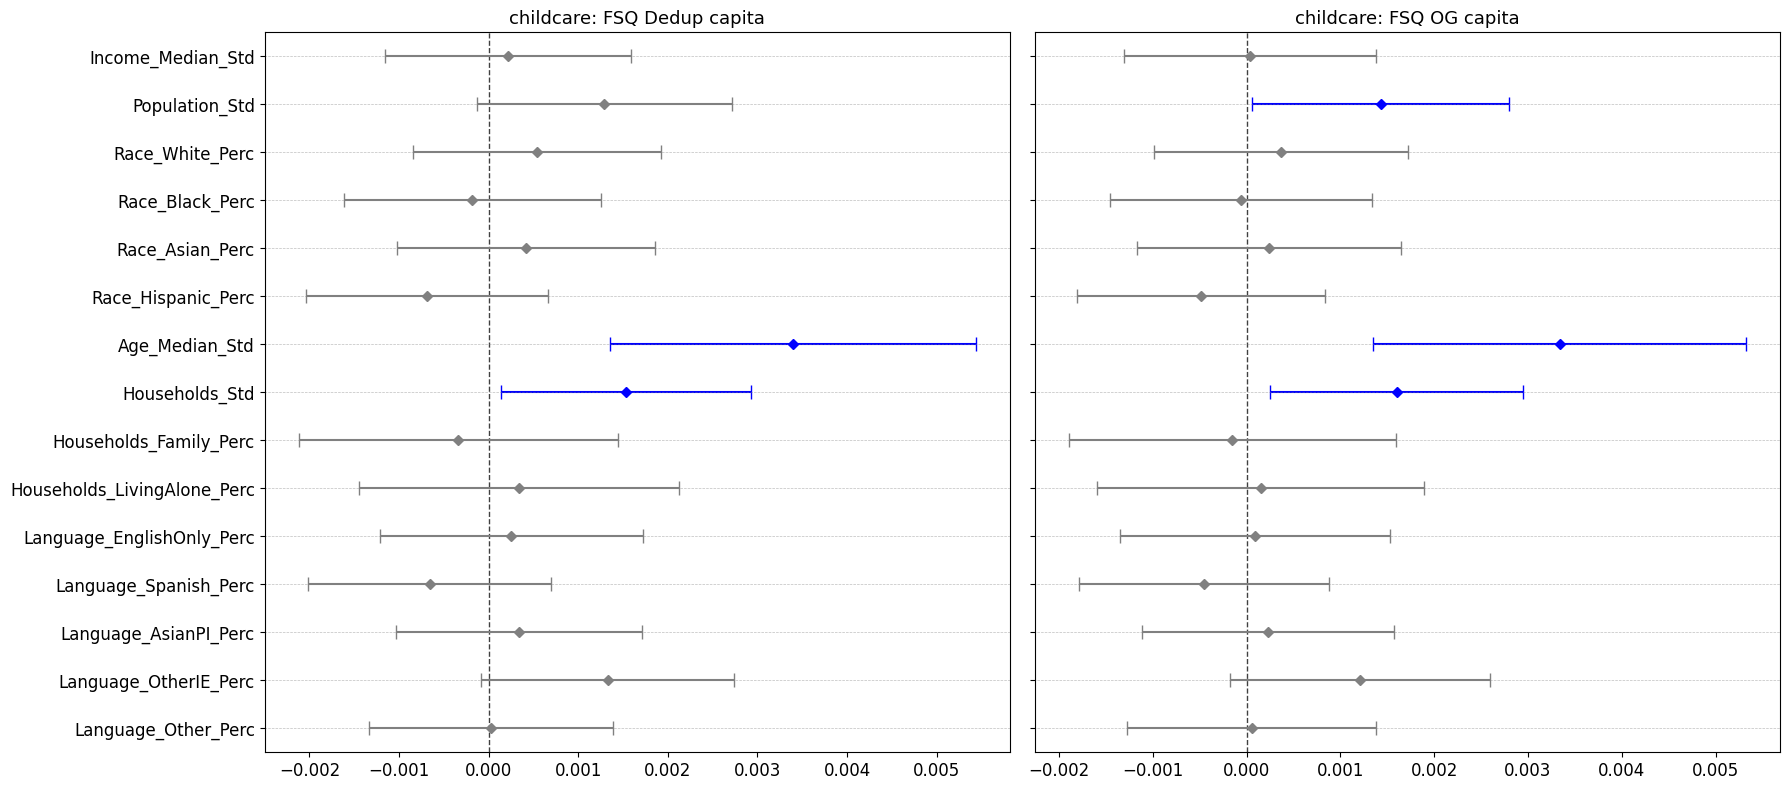

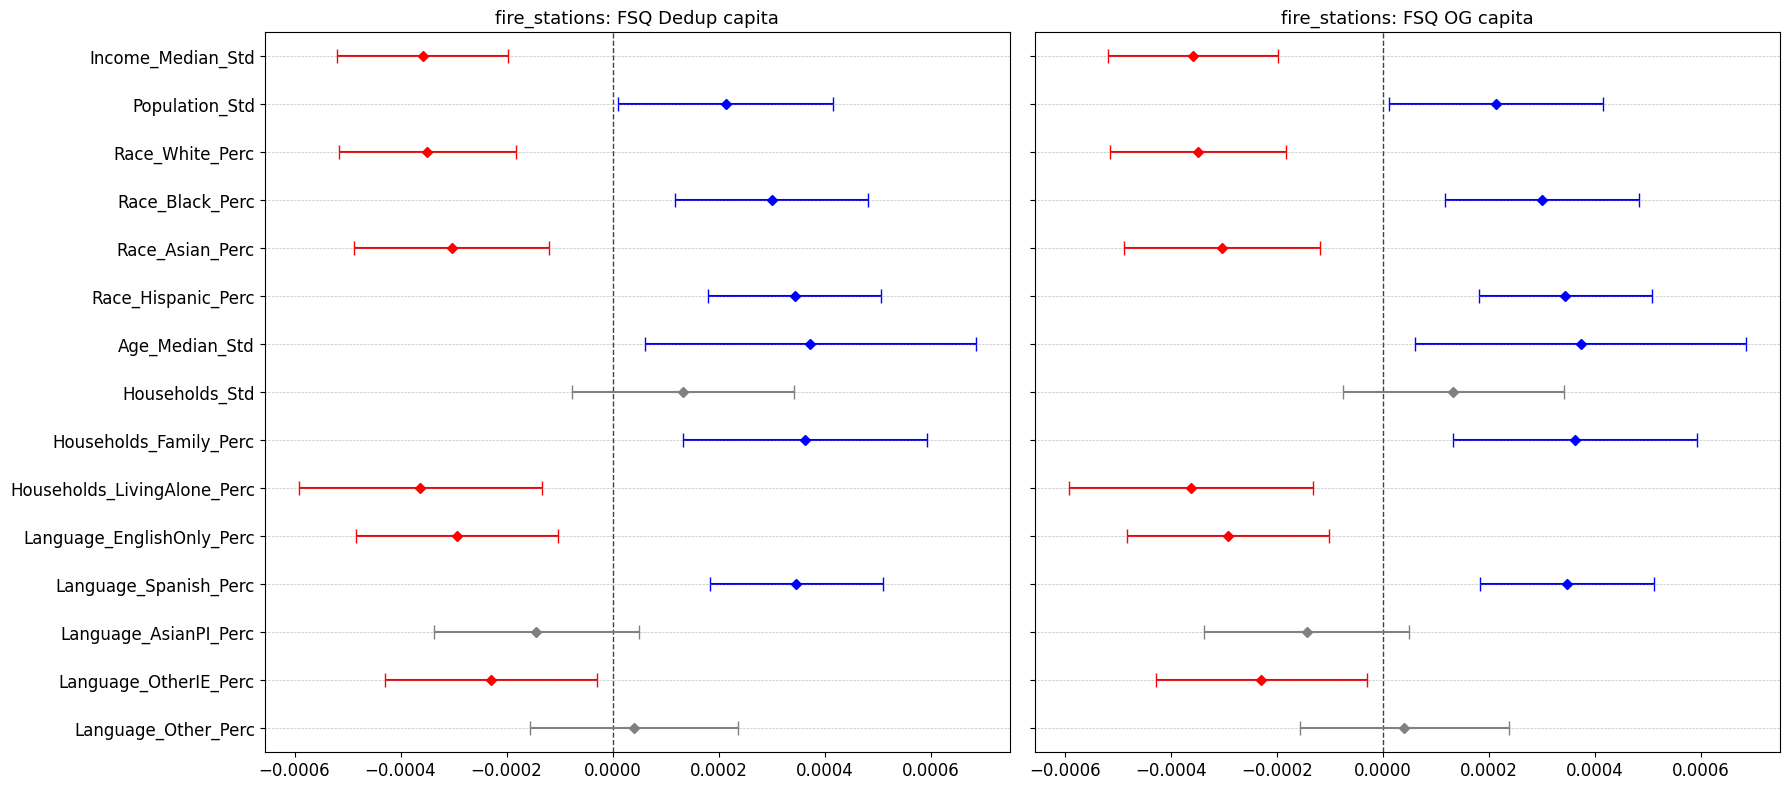

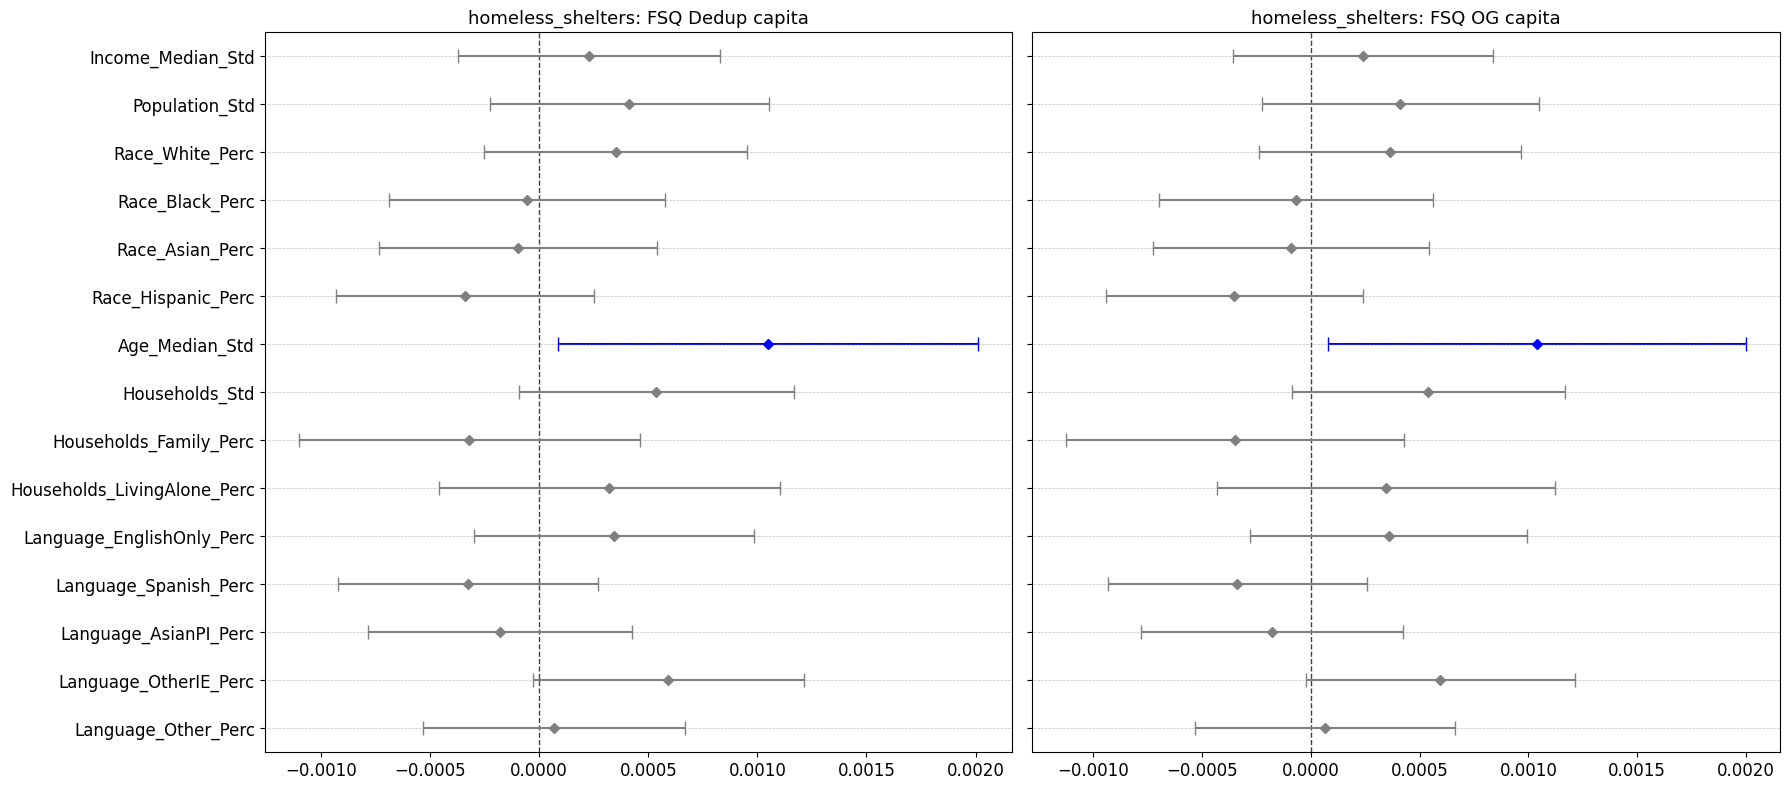

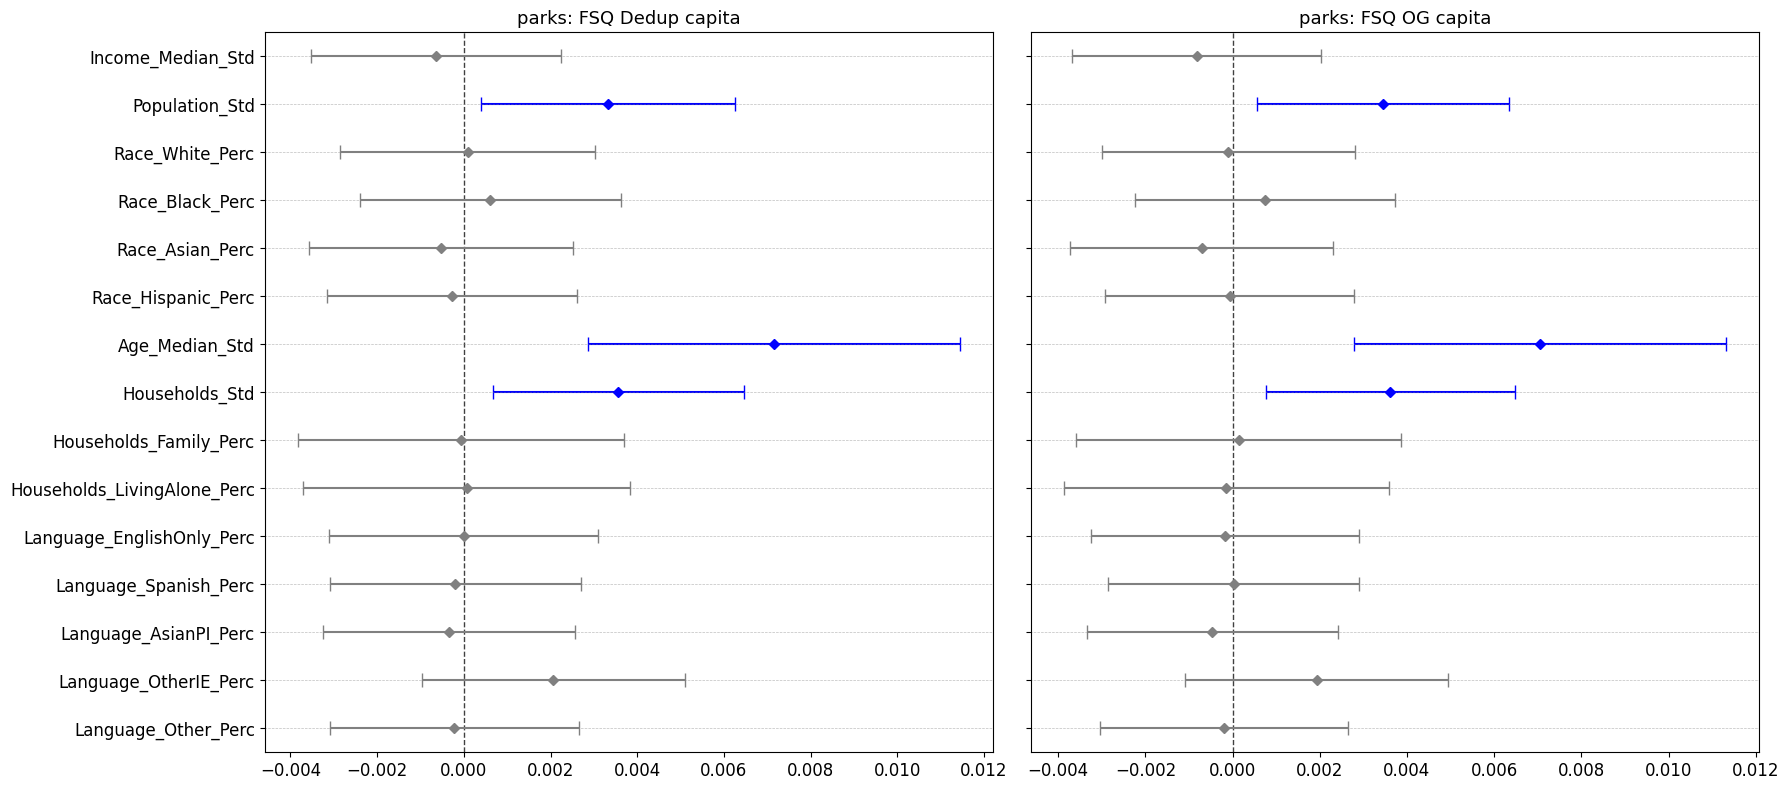

In [ ]:
# Original Code to Generate All ZBP/FSQ Counts by Zip and Category:
# zcta = gpd.read_file('/share/garg/accessgaps2024/fsq_cleaning/data/tl_2020_us_zcta520/tl_2020_us_zcta520.shp')
# zcta = zcta.to_crs("EPSG:3857")  # ensure same CRS
# years = ['16', '17', '18', '19', '20', '21', '22']

# all_zip_data = []
# for y in years:
#     path = f"/share/garg/accessgaps2024/d01_data/d03_Census-spatial-raw-data/zbp15-22/zbp{y}detail.txt"
#     df = pd.read_csv(path, sep = ",")
#     df['year'] = '20' + y
#     all_zip_data.append(df)

# res_data = pd.concat(all_zip_data, ignore_index = True)
# res_data['naics_clean'] = res_data['naics'].astype(str).apply(clean_naics)
# res_data['lander_category'] = res_data['naics_clean'].apply(lambda x: assign_label(x, lander_naics_mapping))
# # res_data = res_data[~((res_data['top_category'].isna()) & (res_data['lander_category'].isna()))]
# res_data = res_data[~(res_data['lander_category'].isna())]

# nyc_zips = ['100', '112', '113', '114', '104', '103']
# def filter_res_by_zips(res_data, zip_lst):
#     def check_if_in_res(zip):
#         s = str(zip)
#         return True if any(s.startswith(suff) for suff in zip_lst) and len(s) == 5 else False
#     return res_data[res_data['zip'].apply(check_if_in_res)]

# res_nyc = filter_res_by_zips(res_data, nyc_zips)
# zbp_counts_per_cat = res_nyc
# zbp_counts_per_cat = (
#     zbp_counts_per_cat.groupby(['zip', 'lander_category', 'year'])['est']
#     .count().reset_index().rename(columns={'est': 'COUNT(ZBP)'})
# )

# -------------------------------------------------------
# og_counts = []
# dup_counts = []
# lander_categories = ['childcare', 'fire_stations', 'parks', 'police_precincts', 'social_services', 'waste_management', 'homeless_shelter']

# df_all_cats = []
# dedups_all_cats = []
# for c in lander_categories:
#     df_all_cats.append(pd.read_csv(f"/share/garg/accessgaps2024/fsq_cleaning/lander_dfs/{c}.csv"))
#     dedups_all_cats.append(pd.read_csv(f"/share/garg/accessgaps2024/fsq_cleaning/lander_dfs/{c}_dedup.csv"))

# df_all_cats = pd.concat(df_all_cats, ignore_index = True)
# df_all_cats['geometry'] = df_all_cats['geometry'].apply(wkt.loads)
# df_all_cats = gpd.GeoDataFrame(df_all_cats,  geometry='geometry', crs="EPSG:4326")

# dedups_all_cats = pd.concat(dedups_all_cats, ignore_index = True)
# dedups_all_cats['geometry'] = dedups_all_cats['geometry'].apply(wkt.loads)
# dedups_all_cats = gpd.GeoDataFrame(dedups_all_cats,  geometry='geometry', crs="EPSG:4326")

# df_all_cats['date_created'] = pd.to_datetime(df_all_cats['date_created'], errors='coerce')
# df_all_cats['date_closed'] = pd.to_datetime(df_all_cats['date_closed'], errors='coerce')

# dedups_all_cats['date_created'] = pd.to_datetime(dedups_all_cats['date_created'], errors='coerce')
# dedups_all_cats['date_closed'] = pd.to_datetime(dedups_all_cats['date_closed'], errors='coerce')

# z_str = f"{int(z):05d}"
# df_all_cats['postcode'] = df_all_cats['postcode'].astype(str).str.extract(r'(\d{5})')[0]
# dedups_all_cats['postcode'] = dedups_all_cats['postcode'].astype(str).str.extract(r'(\d{5})')[0]

# pois_in_zip = df_all_cats[df_all_cats['postcode'] == z_str]
# dedups_in_zip = dedups_all_cats[dedups_all_cats['postcode'] == z_str]

# for y in years:
#     start_date = f"20{y}-01-01"
#     end_date = f"20{int(y)+1}-01-01"
#     pois_zip_y = pois_in_zip[
#         (pois_in_zip['date_created'] < start_date) &
#         ((pois_in_zip['date_closed'].isna()) | (pois_in_zip['date_closed'] >= end_date))
#     ]
#     og_count = (
#         pois_zip_y.groupby('lander_category')['fsq_place_id']
#         .count().reset_index().rename(columns={'fsq_place_id': 'COUNT(OG)'})
#     )
#     og_count['year'] = '20' + y
#     og_count['zip'] = z
#     og_counts.append(og_count)

#     # Dedup
#     # dedups_in_zip = filter_by_zcta(dedups_all_cats, zcta, [z])
#     dedups_zip_y = dedups_in_zip[
#                 (dedups_in_zip['date_created'] < start_date) &
#                 ((dedups_in_zip['date_closed'].isna()) | (dedups_in_zip['date_closed'] >= end_date))
#             ]
#     dup_count = (
#         dedups_zip_y.groupby('lander_category')['fsq_place_id']
#         .count().reset_index().rename(columns={'fsq_place_id': 'COUNT(Dedup)'})
#     )
#     dup_count['year'] = '20' + y
#     dup_count['zip'] = z
#     dup_counts.append(dup_count)
# print("zbp_counts_per_cat")
# print(zbp_counts_per_cat)
# og_df = pd.concat(og_counts, ignore_index=True)
# print("og_df")
# print(og_df)
# dup_df = pd.concat(dup_counts, ignore_index=True)
# print("dup_df")
# print(dup_df)

# # Get all years and categories
# years_full = ['20' + y for y in years]
# categories = df_all_cats['lander_category'].dropna().unique()

# # Ensure 'zip' is a string for merge
# zbp_counts_per_cat['zip'] = zbp_counts_per_cat['zip'].astype(str).str.zfill(5)
# og_df['zip'] = og_df['zip'].astype(str).str.zfill(5)
# dup_df['zip'] = dup_df['zip'].astype(str).str.zfill(5)

# # Build full index
# full_index = pd.MultiIndex.from_product(
# [[z_str], categories, years_full],
# names=['zip', 'lander_category', 'year']
# ).to_frame(index=False)

# # Merge all onto the full index
# joined = (
# full_index
# .merge(zbp_counts_per_cat, on=['zip', 'lander_category', 'year'], how='left')
# .merge(og_df, on=['zip', 'lander_category', 'year'], how='left')
# .merge(dup_df, on=['zip', 'lander_category', 'year'], how='left')
# )

# # Fill missing counts with 0
# joined[['COUNT(ZBP)', 'COUNT(OG)', 'COUNT(Dedup)']] = joined[
# ['COUNT(ZBP)', 'COUNT(OG)', 'COUNT(Dedup)']
# ].fillna(0)

# df_all_cats = df_all_cats[df_all_cats['postcode'].notna()]
# dedups_all_cats = dedups_all_cats[dedups_all_cats['postcode'].notna()]
# counts_by_zip = joined.groupby(by = ['zip', 'lander_category', 'year'])[['COUNT(ZBP)', 'COUNT(OG)', 'COUNT(Dedup)']].sum().reset_index()
# print("counts_by_zip")
# print(counts_by_zip)
# print("made it")
# # Optional: save results per zip
# counts_by_zip.to_csv(f"/share/garg/accessgaps2024/fsq_cleaning/results_by_zip_{z}_cat.csv")

# -------------------------------------------------
# Original code to generate CIs and plot residuals:
# zips_done = [10001, 10002, 10003, 10004, 10005, 10006, 10007, 10009, 10010, 10011, 10012, 10013, 
#     10014, 10016, 10017, 10018, 10019, 10021, 10023, 10024, 10025, 10026, 10027, 
#     10028, 10029, 10030, 10031, 10032, 10033, 10034, 10035, 10037, 10038, 10039, 
#     10040, 10044, 10069, 10103, 10119, 10128, 10162, 10165, 10170, 10173, 10199, 10279, 
#     10280, 10282]
# counts_all_zips = []
# for i in zips_done:
#     counts_all_zips.append(pd.read_csv(f"/share/garg/accessgaps2024/fsq_cleaning/results/results_by_zip_{i}_cat.csv"))

# df_all_zips = pd.concat(counts_all_zips, ignore_index = True)
# df_all_zips = df_all_zips.groupby(by = ['zip', 'lander_category'])[['COUNT(ZBP)', 'COUNT(OG)', 'COUNT(Dedup)']].sum().reset_index()

# df_all_zips['ZBP_Share'] = df_all_zips.groupby("zip")['COUNT(ZBP)'].transform(lambda x: x / x.sum() if x.sum() > 0 else 0) 
# df_all_zips['OG_Share'] = df_all_zips.groupby("zip")['COUNT(OG)'].transform(lambda x: x / x.sum() if x.sum() > 0 else 0)
# df_all_zips['Dedup_Share'] = df_all_zips.groupby("zip")['COUNT(Dedup)'].transform(lambda x: x / x.sum() if x.sum() > 0 else 0)

# df_all_zips['zip'] = df_all_zips['zip'].astype(str).str.zfill(5)
# counts_pop = df_all_zips.merge(pop_man[['zip', 'Population']], on = 'zip', how = 'left')
# counts_pop['OG_Per_Capita'] = counts_pop['COUNT(OG)'] / counts_pop['Population']
# counts_pop['Dedup_Per_Capita'] = counts_pop['COUNT(Dedup)'] / counts_pop['Population']
# counts_pop['ZBP_Per_Capita'] = counts_pop['COUNT(ZBP)'] / counts_pop['Population']
# stats = produce_stats_zbp_fsq_counts(counts_pop)
# residuals_df = calculate_residuals_zbp_fsq_counts(df_all_zips)
# plot_residuals_against_demographics(df_all_zips, residuals_df, zips_done, lander_categories = (['childcare', 'fire_stations', 'homeless_shelters', 'parks']), residual_type = 'capita')


### Using Ground Truth Datasets for Validation

/tmp/ipykernel_2306379/871152784.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fsq_og_df['geometry'] = fsq_og_df['geometry'].apply(wkt.loads)
/tmp/ipykernel_2306379/871152784.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fsq_dedup_df['geometry'] = fsq_dedup_df['geometry'].apply(wkt.loads)


All counts for each zip:    postcode  COUNT(FH)  COUNT(OG)  COUNT(Dedup)
0     10002          1          4             4
1     10003          1          4             4
2     10011          1          3             3
3     10013          2          5             5
4     10014          1          3             3
..      ...        ...        ...           ...
67    11418          1          2             2
68    11422          1          3             3
69    11432          1          3             3
70    11691          1          2             2
71    11693          1          3             3

[72 rows x 4 columns]
fsq_og_df crs: EPSG:4326
fsq_dedup_df crs: EPSG:4326
0 empty geometries in fire_dedup
388 valid geometries in fire_dedup
0 empty geometries in fire_og
390 valid geometries in fire_og
fsq_dedup_df total: 388
fsq_og_df total: 390
OG FSQ matched within 100m: 17
Deduplicated FSQ matched within 100m: 17
Only Ground Truth (Red): 13.9%
Only FSQ (Blue): 79.4%
Overlap (~50m buffer):

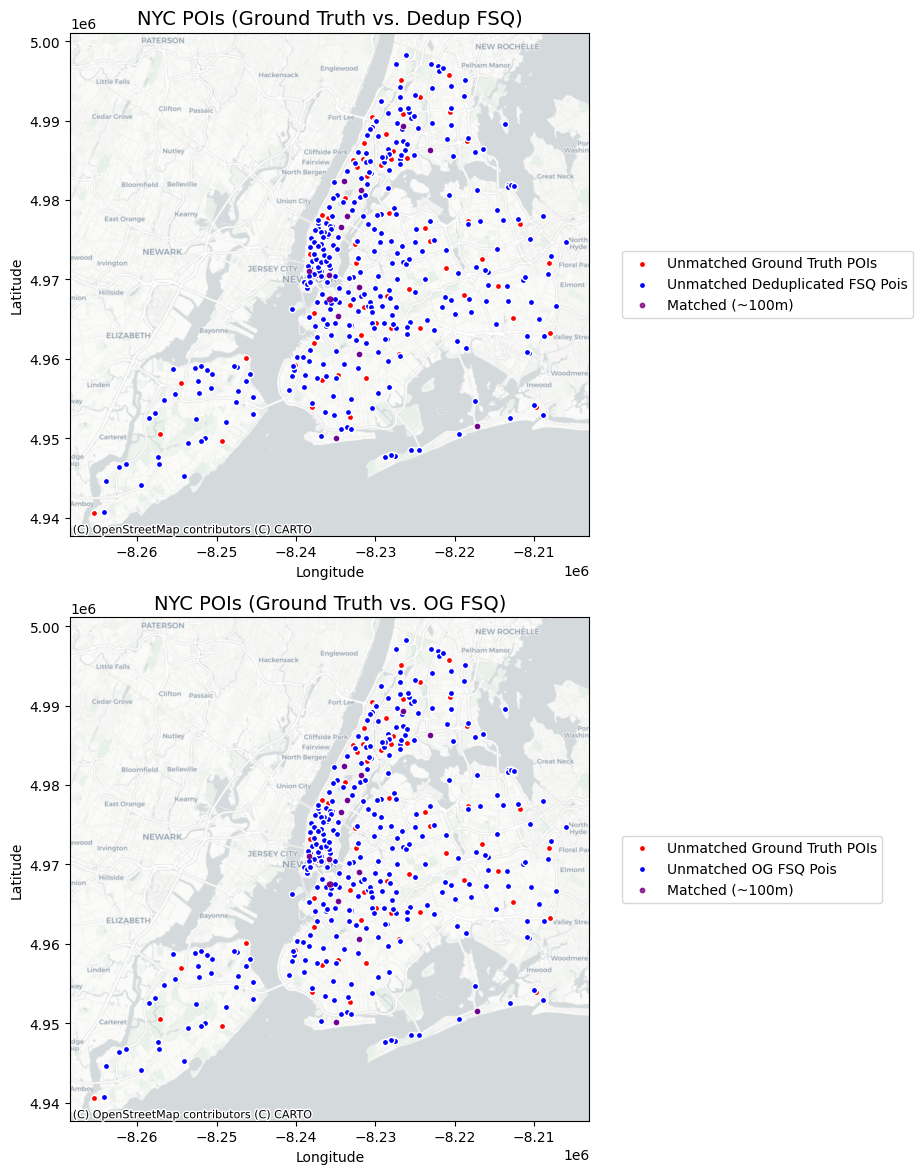

In [ ]:
def produce_plot_all_counts_gt_fsq(ground_truth_gdf, fsq_og_df, fsq_dedup_df, plot = False):
    """
    Generates and returns a DataFrame for ground truth and FSQ og and dedup counts for each zipcode.
    Parameters:
        ground_truth_gdf (GeoDataFrame): ground truth shapefile with a ZIPCODE column. Look at:
            # firehouses from NYCityMap: "/share/garg/accessgaps2024/fsq_dedup_pipeline/data/firehouses/FacDB_20220630.shp"
            # police stations from NYCityMap: "/share/garg/accessgaps2024/fsq_dedup_pipeline/data/police_stations/FacDB_20220630.shp"
            for examples of valid shapefiles.
        fsq_og_df (DataFrame): FSQ DataFrame with unfiltered POIs. Must have columns 'fsq_place_id', 'postcode', 'date_created', 'date_closed', and 'geometry'.
        fsq_dedup_df (DataFrame): FSQ deduplicated DataFrame (check /share/garg/accessgaps2024/fsq_dedup_pipeline/results).  
                                Must have columns 'fsq_place_id', 'postcode', 'date_created', 'date_closed', and 'geometry'.

    Example usage: 
        firehouses = gpd.read_file("/share/garg/accessgaps2024/fsq_dedup_pipeline/data/firehouses/FacDB_20220630.shp")
        fire_counts = firehouses.groupby('ZIPCODE').size().reset_index(name='COUNT(FH)')
        fire_counts = fire_counts.rename(columns = {"ZIPCODE": "postcode"})
        fire_og = pd.read_csv(f"/share/garg/accessgaps2024/fsq_cleaning/lander_dfs/fire_stations.csv")
        fire_dedup = pd.read_csv(f"/share/garg/accessgaps2024/fsq_cleaning/lander_dfs/fire_stations_dedup.csv")
        df_all = process_produce_all_counts_gt_fsq(firehouses, fire_og, fire_dedup)
        df_all
    """
    ground_truth_counts = ground_truth_gdf.groupby('ZIPCODE').size().reset_index(name='COUNT(FH)')
    ground_truth_counts = ground_truth_counts.rename(columns = {"ZIPCODE": "postcode"})

    fsq_og_df['date_created'] = pd.to_datetime(fsq_og_df['date_created'], errors='coerce')
    fsq_og_df['date_closed'] = pd.to_datetime(fsq_og_df['date_closed'], errors='coerce')
    fsq_dedup_df['date_created'] = pd.to_datetime(fsq_dedup_df['date_created'], errors='coerce')
    fsq_dedup_df['date_closed'] = pd.to_datetime(fsq_dedup_df['date_closed'], errors='coerce')

    fsq_og_df = fsq_og_df[fsq_og_df['date_closed'].isna()]
    fsq_dedup_df = fsq_dedup_df[fsq_dedup_df['date_closed'].isna()]
    fsq_og_df['geometry'] = fsq_og_df['geometry'].apply(wkt.loads)
    fsq_dedup_df['geometry'] = fsq_dedup_df['geometry'].apply(wkt.loads)

    og_count = (
            fsq_og_df.groupby('postcode')['fsq_place_id']
            .count().reset_index().rename(columns={'fsq_place_id': 'COUNT(OG)'})
        )
    dup_count = (
            fsq_dedup_df.groupby('postcode')['fsq_place_id']
            .count().reset_index().rename(columns={'fsq_place_id': 'COUNT(Dedup)'})
        )

    df_all = ground_truth_counts.merge(og_count, on = "postcode", how = "inner").merge(dup_count, on = "postcode", how = "inner")

    if not plot:
        return df_all
    else:
        print("All counts for each zip: " + str(df_all))
        fsq_dedup_df = gpd.GeoDataFrame(fsq_dedup_df,  geometry='geometry', crs="EPSG:4326")
        fsq_og_df = gpd.GeoDataFrame(fsq_og_df,  geometry='geometry', crs="EPSG:4326")

        print("fsq_og_df crs: " + str(fsq_og_df.crs))
        print("fsq_dedup_df crs: " + str(fsq_dedup_df.crs))

        print(fsq_dedup_df.geometry.is_empty.sum(), "empty geometries in fire_dedup")
        print(fsq_dedup_df.geometry.is_valid.sum(), "valid geometries in fire_dedup")

        print(fsq_og_df.geometry.is_empty.sum(), "empty geometries in fire_og")
        print(fsq_og_df.geometry.is_valid.sum(), "valid geometries in fire_og")

        # Rough NYC bounding box (in WGS84)
        MIN_LON, MAX_LON = -74.3, -73.65
        MIN_LAT, MAX_LAT = 40.45, 41.0

        # Remove any geometry near (0, 0)
        def is_near_zero(point, threshold=0.01):  # ~1 km at equator
            return abs(point.x) < threshold and abs(point.y) < threshold

        fsq_og_df = fsq_og_df[
            (fsq_og_df.geometry.x >= MIN_LON) & (fsq_og_df.geometry.x <= MAX_LON) &
            (fsq_og_df.geometry.y >= MIN_LAT) & (fsq_og_df.geometry.y <= MAX_LAT)
        ]

        fsq_dedup_df = fsq_dedup_df[~fsq_dedup_df.geometry.apply(is_near_zero)]
        fsq_dedup_df = fsq_dedup_df[
            (fsq_dedup_df.geometry.x >= MIN_LON) & (fsq_dedup_df.geometry.x <= MAX_LON) &
            (fsq_dedup_df.geometry.y >= MIN_LAT) & (fsq_dedup_df.geometry.y <= MAX_LAT)
        ]
        print("fsq_dedup_df total:", len(fsq_dedup_df))
        print("fsq_og_df total:", len(fsq_og_df))

        # Convert CRS to EPSG:3857 (Web Mercator) for basemap compatibility
        ground_truth_proj = ground_truth_gdf.to_crs(epsg=3857)
        fsq_dedup_proj = fsq_dedup_df.to_crs(epsg=3857)
        fsq_og_proj = fsq_dedup_proj.to_crs(epsg=3857)

        # Buffer ground truth by 100 meters (CRS: EPSG:3857 = meters)
        ground_truth_buffered = ground_truth_proj.copy()
        ground_truth_buffered['geometry'] = ground_truth_proj.buffer(100)  # 100 meters

        # Spatial join: which FSQ points fall within the buffer?
        fsq_og_within_100m = gpd.sjoin(fsq_og_proj, ground_truth_buffered, how='inner', predicate='within')
        fsq_dedup_within_100m = gpd.sjoin(fsq_dedup_proj, ground_truth_buffered, how='inner', predicate='within')

        print("OG FSQ matched within 100m:", len(fsq_og_within_100m))
        print("Deduplicated FSQ matched within 100m:", len(fsq_dedup_within_100m))

        compute_overlap_stats(fsq_dedup_proj, ground_truth_proj, buffer_dist = 50)
        compute_overlap_stats(fsq_og_proj, ground_truth_proj, buffer_dist = 50)

        # Create figure and axis
        fig, ax = plt.subplots(2, 1, figsize=(16, 12))

        # Plot both layers
        ground_truth_proj.plot(ax = ax[0], color='red', edgecolor='white', alpha = 1, label='Unmatched Ground Truth POIs', markersize = 20)
        fsq_dedup_proj.plot(ax = ax[0], color='blue', edgecolor='white', alpha = 1, label='Unmatched Deduplicated FSQ Pois', markersize = 20)
        ground_truth_proj.plot(ax = ax[1], color='red', edgecolor='white', alpha = 1, label='Unmatched Ground Truth POIs', markersize = 20)
        fsq_og_proj.plot(ax = ax[1], color='blue', edgecolor='white', alpha = 1, label='Unmatched OG FSQ Pois', markersize = 20)

        # Plot matched FSQ POIs on top
        fsq_dedup_within_100m.plot(ax=ax[0], color='purple', markersize=10, label='Matched (~100m)', alpha=0.8)
        fsq_og_within_100m.plot(ax=ax[1], color='purple', markersize=10, label='Matched (~100m)', alpha=0.8)

        # Add basemap
        ctx.add_basemap(ax = ax[0], source=ctx.providers.CartoDB.Positron)
        ctx.add_basemap(ax = ax[1], source=ctx.providers.CartoDB.Positron)

        # Styling
        ax[0].set_title("NYC POIs (Ground Truth vs. Dedup FSQ)", fontsize=14)
        ax[0].set_xlabel("Longitude")
        ax[0].set_ylabel("Latitude")

        ax[1].set_title("NYC POIs (Ground Truth vs. OG FSQ)", fontsize=14)
        ax[1].set_xlabel("Longitude")
        ax[1].set_ylabel("Latitude")

        for a in ax:
            a.set_xlabel("Longitude")
            a.set_ylabel("Latitude")
            a.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

        plt.tight_layout()
        plt.show()


def print_stats_for_gt_fsq_dfs(df_all):
    """ 
    Prints the RMSE and Pearson correlation for the counts, shares, and counts per capita
    metrics between ground truth and FSQ data.

    Parameters (DataFrame): contains all metrics for ground truth and FSQ counts, df_all.
                            Obtain by running produce_plot_all_counts_gt_fsq(..., plot = False).
    """
    print("Analysis by POI Counts")
    fh_count = df_all['COUNT(FH)']
    rmse_count_og = np.sqrt(mean_squared_error(fh_count, df_all['COUNT(OG)']))
    rmse_count_dedup = np.sqrt(mean_squared_error(fh_count, df_all['COUNT(Dedup)']))

    df_all["RMSE_COUNT(OG)"] = rmse_count_og
    df_all["RMSE_COUNT(Dedup)"] = rmse_count_dedup

    # Pearson correlation
    pearson_corr_og, pearson_p_og = pearsonr(fh_count, df_all['COUNT(OG)'])
    pearson_corr_dedup, pearson_p_dedup = pearsonr(fh_count, df_all['COUNT(Dedup)'])

    print("pearson corr between og and ground truth: " + str(pearson_corr_og))
    print("pearson p-value: " + str(pearson_p_og))
    print("pearson corr between dedup and ground truth: " + str(pearson_corr_dedup))
    rmse_inc = round(100*((pearson_corr_dedup - pearson_corr_og) / pearson_corr_og), 2)
    print("pearson p-value: " + str(pearson_p_dedup))
    print("% pearson corr improvement: " + str(rmse_inc) + "%")

    print("og rmse: " + str(rmse_count_og))
    print("dedup rmse: " + str(rmse_count_dedup))
    rmse_red = round(100*((rmse_count_dedup - rmse_count_og) / rmse_count_og), 2)
    print("% rmse reduction: " + str(rmse_red) + "%")
    df_all["RMSE_Red_Count"] = rmse_red

    print()
    print("Analysis by POI Counts Per Capita (measured in 10^6)")

    fh_capita = df_all['FH_Per_Capita']
    # rmse_capita_og = np.sqrt(mean_squared_error(fh_capita, round(counts_pop['OG_Per_Capita'], 2)))
    # Ensure the two arrays/Series have the same index and no NaNs or infs
    fh_capita_clean = np.array(fh_capita)
    og_per_capita_clean = np.array(df_all['OG_Per_Capita'].round(2))
    dedup_per_capita_clean = np.array(df_all['Dedup_Per_Capita'].round(2))

    # Combine and filter invalid entries
    valid_mask = (
        np.isfinite(fh_capita_clean) &
        np.isfinite(og_per_capita_clean)
    )

    # Compute RMSE only on valid entries
    rmse_capita_og = np.sqrt(
        mean_squared_error(
            fh_capita_clean[valid_mask],
            og_per_capita_clean[valid_mask]
        )
    )

    rmse_capita_dedup = np.sqrt(
        mean_squared_error(
            fh_capita_clean[valid_mask],
            dedup_per_capita_clean[valid_mask]
        )
    )

    df_all['RMSE_OG_Per_Capita'] = rmse_capita_og
    df_all['RMSE_Dedup_Per_Capita'] = rmse_capita_dedup

    # Pearson correlation
    pearson_corr_og, pearson_p_og = pearsonr(fh_capita_clean[valid_mask], og_per_capita_clean[valid_mask])
    pearson_corr_dedup, pearson_p_dedup = pearsonr(fh_capita_clean[valid_mask], dedup_per_capita_clean[valid_mask])

    print("pearson corr between og and ground truth: " + str(pearson_corr_og))
    print("pearson p-value: " + str(pearson_p_og))
    print("pearson corr between dedup and ground truth: " + str(pearson_corr_dedup))
    rmse_inc = round(100*((pearson_corr_dedup - pearson_corr_og) / pearson_corr_og), 2)
    print("pearson p-value: " + str(pearson_p_dedup))
    print("% pearson corr improvement: " + str(rmse_inc) + "%")

    print("og rmse (mega: M): " + str(rmse_capita_og))
    print("dedup rmse (mega: M): " + str(rmse_capita_dedup))
    rmse_red = round(100*((rmse_capita_dedup - rmse_capita_og) / rmse_capita_og), 2)
    print("% rmse reduction: " + str(rmse_red) + "%")
    df_all["RMSE_Red_Capita"] = rmse_red

## EXAMPLE USAGE:
# firehouses = gpd.read_file("/share/garg/accessgaps2024/fsq_dedup_pipeline/data/police_stations/FacDB_20220630.shp")
# fire_counts = firehouses.groupby('ZIPCODE').size().reset_index(name='COUNT(FH)')
# fire_counts = fire_counts.rename(columns = {"ZIPCODE": "postcode"})
# fire_og = pd.read_csv(f"/share/garg/accessgaps2024/fsq_cleaning/lander_dfs/fire_stations.csv")
# fire_dedup = pd.read_csv(f"/share/garg/accessgaps2024/fsq_cleaning/lander_dfs/fire_stations_dedup.csv")
# df_all = produce_plot_all_counts_gt_fsq(firehouses, fire_og, fire_dedup, plot = True)
# df_all
# firehouses = gpd.read_file("/share/garg/accessgaps2024/fsq_dedup_pipeline/data/firehouses/FacDB_20220630.shp")
# fire_counts = firehouses.groupby('ZIPCODE').size().reset_index(name='COUNT(FH)')
# fire_counts = fire_counts.rename(columns = {"ZIPCODE": "postcode"})
# fire_og = pd.read_csv(f"/share/garg/accessgaps2024/fsq_cleaning/lander_dfs/fire_stations.csv")
# fire_dedup = pd.read_csv(f"/share/garg/accessgaps2024/fsq_cleaning/lander_dfs/fire_stations_dedup.csv")

# fire_og['date_created'] = pd.to_datetime(fire_og['date_created'], errors='coerce')
# fire_og['date_closed'] = pd.to_datetime(fire_og['date_closed'], errors='coerce')
# fire_dedup['date_created'] = pd.to_datetime(fire_dedup['date_created'], errors='coerce')
# fire_dedup['date_closed'] = pd.to_datetime(fire_dedup['date_closed'], errors='coerce')

# fire_og = fire_og[fire_og['date_closed'].isna()]
# fire_dedup = fire_dedup[fire_dedup['date_closed'].isna()]
# fire_og['geometry'] = fire_og['geometry'].apply(wkt.loads)
# fire_dedup['geometry'] = fire_dedup['geometry'].apply(wkt.loads)

# og_count = (
#         fire_og.groupby('postcode')['fsq_place_id']
#         .count().reset_index().rename(columns={'fsq_place_id': 'COUNT(OG)'})
#     )
# dup_count = (
#         fire_dedup.groupby('postcode')['fsq_place_id']
#         .count().reset_index().rename(columns={'fsq_place_id': 'COUNT(Dedup)'})
#     )

# df_all = fire_counts.merge(og_count, on = "postcode", how = "inner").merge(dup_count, on = "postcode", how = "inner")
# fig, ax = plt.subplots(1, 1, figsize=(16, 12))
# firehouses.plot(ax=ax, color='red', alpha=0.5)

### EXTRA

NameError: name 'r2_score' is not defined

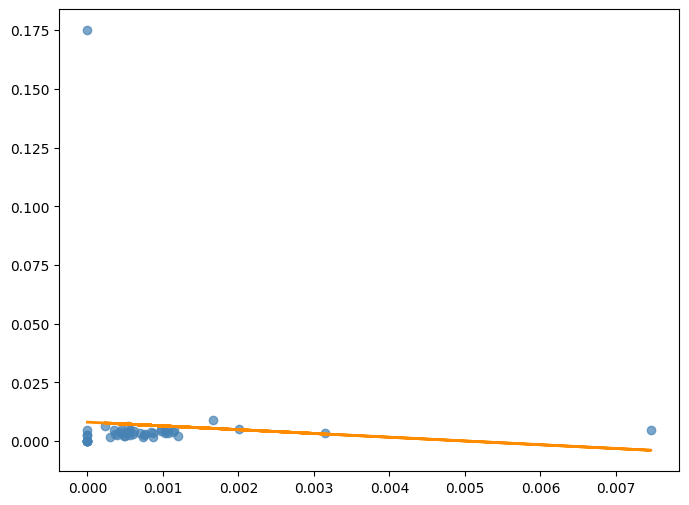

In [11]:
childcare_data = residuals_df[residuals_df['category'] == 'childcare']
# # childcare_data

x = childcare_data['ZBP_Per_Capita']
y = childcare_data['Dedup_Per_Capita']

# Fit linear regression: y = m*x + b
m, b = np.polyfit(x, y, 1)

# Plot scatter
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='steelblue', alpha=0.7, label='Data')

# Plot best fit line
plt.plot(x, m * x + b, color='darkorange', linewidth=2, label='Best Fit Line')
r2 = r2_score(y, m * x + b)
print(f"R-squared: {r2:.3f}")


# # Apply LOWESS smoothing
# lowess = sm.nonparametric.lowess
# smoothed = lowess(y, x, frac=0.3)  # adjust frac (0.2–0.5) for more or less smoothing

# # Plot scatter
# plt.figure(figsize=(8, 6))
# plt.scatter(x, y, color='steelblue', alpha=0.7, label='Data')

# # Plot LOWESS line
# plt.plot(smoothed[:, 0], smoothed[:, 1], color='darkorange', linewidth=2, label='LOWESS Smoothed Line')

# Labels and legend
plt.xlabel("ZBP Per Capita")
plt.ylabel("Dedup Per Capita")
# plt.xlim(0, 0.025)
# plt.ylim(0, 0.025)
# plt.axis("equal", adjustable = "box")
# ax.set_aspect('equal', adjustable = "box")

plt.title("Childcare: ZBP vs. Dedup Counts Per Capita")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.axis("equal")
plt.show()

In [ ]:
man_fsq_pois = pd.read_parquet("/share/garg/accessgaps2024/fsq_dedup_pipeline/data/fsq_data/man_fsq_pois")
man_fsq_pois['lander_category'] = man_fsq_pois['fsq_category_labels'].apply(lambda x: get_lander_category(x, lander_fsq_mapping) if isinstance(x, np.ndarray) else None)

from shapely import wkb
# man_fsq_pois['geometry'] = man_fsq_pois['geometry'].apply(wkb.loads)
man_fsq_pois = gpd.GeoDataFrame(man_fsq_pois, geometry='geometry', crs="EPSG:4326")
child_outliers = man_fsq_pois[(man_fsq_pois['postcode'].isin(["10004", "10170"])) & (man_fsq_pois['lander_category'] == 'childcare')]
child_outliers_10004 = child_outliers[child_outliers['postcode'] == '10004']
print("len(10004_childcare_og): " + str(len(child_outliers_10004)))
child_outliers_10004, labeled_10004, metrics_df_10004 = await deduplicate(child_outliers_10004, max_distance = 100, name_similarity_threshold = 90, precision = 1, blacklist = NYC_BLACKLIST, file_name = '/share/garg/accessgaps2024/fsq_dedup_pipeline/results/fsq_10004_test')
child_outliers_10170 = child_outliers[child_outliers['postcode'] == '10170']
child_outliers_10170, labeled_10170, metrics_df_10170 = await deduplicate(child_outliers_10170, max_distance = 100, name_similarity_threshold = 90, precision = 1, blacklist = NYC_BLACKLIST, file_name = '/share/garg/accessgaps2024/fsq_dedup_pipeline/results/fsq_10004_test')
child_outliers_10170

len(10004_childcare_og): 7
num hashes: 1
num hashes: 1


/share/garg/accessgaps2024/fsq_dedup_pipeline/deduplication/other_utils.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[kept, 'resolved_fsq_id'] = df.loc[kept, 'fsq_place_id']
/share/garg/accessgaps2024/fsq_dedup_pipeline/deduplication/other_utils.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[kept, 'resolved_fsq_id'] = df.loc[kept, 'fsq_place_id']


,fsq_place_id,name,latitude,longitude,address,locality,region,postcode,admin_region,post_town,...,placemaker_url,unresolved_flags,geom,bbox,dt,geometry,top_category,lander_category,geohash,parent_id
0,a8cabe9e4a40f25f0768062b,Bright Horizons Family Solutions,40.752674,-73.975789,420 Lexington Ave Rm 2744,New York,NY,10170,None,None,...,https://foursquare.com/placemakers/review-plac...,None,b'\x00\x00\x00\x00\x01\xc0R~sT<\x96B@D`W\x9f\x...,"{'xmax': -73.97578912655538, 'xmin': -73.97578...",2025-06-10,POINT (-73.976 40.753),Business and Professional Services,childcare,d,


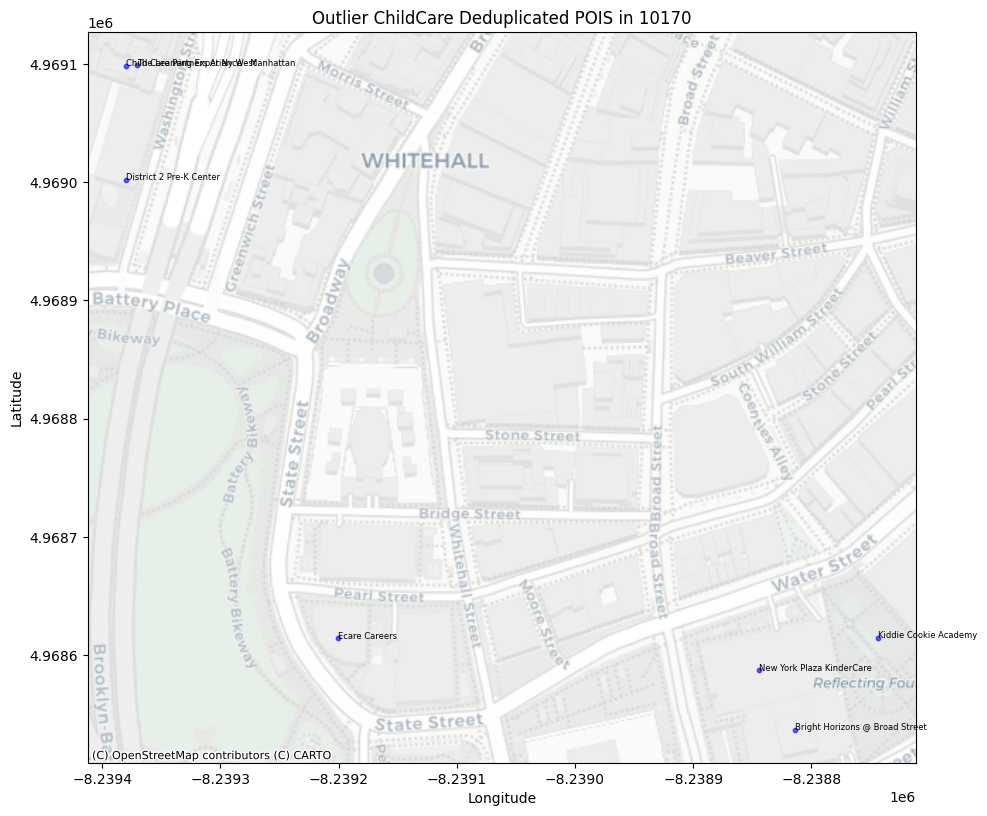

In [151]:
# %pip install contexily
import contextily as ctx
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkb

# child_outliers_10004['geometry'] = child_outliers_10004['geometry'].apply(wkb.loads)

# Convert to GeoDataFrame if not already
child_outliers = child_outliers_10004

child_outliers = gpd.GeoDataFrame(child_outliers, geometry='geometry')

# Set CRS to WGS84 (latitude/longitude)
child_outliers.set_crs(epsg=4326, inplace=True, allow_override=True)

child_outliers_web = child_outliers.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
child_outliers_web.plot(ax=ax, color='blue', markersize=10, alpha=0.6)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# child_outliers_10004 = child_outliers_10004.to_crs()
# Plot base geometry (if available)

# Optional: add labels
for x, y, label in zip(child_outliers_web.geometry.x, child_outliers_web.geometry.y, child_outliers_web['name']):
    ax.text(x, y, label, fontsize=6)

ax.set_title("Outlier ChildCare Deduplicated POIS in 10170")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
# plt.grid(True)
plt.tight_layout()
plt.show()



In [6]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr
import numpy as np
from sklearn.preprocessing import StandardScaler

pop = gpd.read_file('/share/garg/dogathon/d01_data/d02_demographics/ZCTA.gpkg')
pop_man = pop.copy()
pop_man['ZCTA'] = pop_man['ZCTA'].astype(str)
pop_man = pop_man.rename(columns = {'ZCTA': 'postcode'})

counts_pop = df_all.merge(pop_man[['postcode', 'Population']], on = 'postcode', how = 'left')

counts_pop['OG_Per_Capita'] = 1000000 * counts_pop['COUNT(OG)'] / counts_pop['Population']
counts_pop['Dedup_Per_Capita'] = 1000000 * counts_pop['COUNT(Dedup)'] / counts_pop['Population']
counts_pop['FH_Per_Capita'] = 1000000 * counts_pop['COUNT(FH)'] / counts_pop['Population']

# counts_pop['OG_Per_Capita'] = counts_pop['COUNT(OG)'] / counts_pop['Population']
# counts_pop['Dedup_Per_Capita'] = counts_pop['COUNT(Dedup)'] / counts_pop['Population']
# counts_pop['FH_Per_Capita'] = counts_pop['COUNT(FH)'] / counts_pop['Population']
counts_pop

,postcode,COUNT(FH),COUNT(OG),COUNT(Dedup),Population,OG_Per_Capita,Dedup_Per_Capita,FH_Per_Capita
0,10002,1,2,2,82155.0,24.344227,24.344227,12.172114
1,10003,1,5,5,57076.0,87.602495,87.602495,17.520499
2,10011,1,2,2,53318.0,37.510784,37.510784,18.755392
3,10013,2,4,4,31042.0,128.857677,128.857677,64.428838
4,10014,1,4,4,32590.0,122.737036,122.737036,30.684259
...,...,...,...,...,...,...,...,...
67,11428,1,2,1,19516.0,102.480016,51.240008,51.240008
68,11432,1,3,3,65743.0,45.632235,45.632235,15.210745
69,11434,1,2,2,66964.0,29.866794,29.866794,14.933397
70,11691,1,2,2,64673.0,30.924806,30.924806,15.462403


### EXTRA

In [ ]:
### Attempt to use fire_companies data from NYCData for validation
# Link: https://www.nyc.gov/content/planning/pages/resources/datasets/fire-battalions-companies-divisions

zip_lst = list(set([z for lst in fire_companies['zcta'] for z in lst]))
fsq_fire_stations = pd.read_csv("/share/garg/accessgaps2024/fsq_cleaning/lander_dfs/fire_stations.csv")
fsq_zips = list(fsq_fire_stations['postcode'].unique())
is_in = fire_companies['zcta'].apply(lambda lst: all(z in fsq_zips for z in lst) if isinstance(lst, list) else False)
fire_nyc = fire_companies[is_in]
fire_nyc = fire_nyc[fire_nyc['zcta'].notna()]
fire_exploded = fire_nyc.explode('zcta')
fire_counts = fire_exploded.groupby('zcta').size().reset_index(name='fire_station_count')
fire_counts = fire_counts.rename(columns = {"zcta": "postcode"})
fire_og = pd.read_csv(f"/share/garg/accessgaps2024/fsq_cleaning/lander_dfs/fire_stations.csv")
fire_dedup = pd.read_csv(f"/share/garg/accessgaps2024/fsq_cleaning/lander_dfs/fire_stations_dedup.csv")

fire_og['date_created'] = pd.to_datetime(fire_og['date_created'], errors='coerce')
fire_og['date_closed'] = pd.to_datetime(fire_og['date_closed'], errors='coerce')

fire_dedup['date_created'] = pd.to_datetime(fire_dedup['date_created'], errors='coerce')
fire_dedup['date_closed'] = pd.to_datetime(fire_dedup['date_closed'], errors='coerce')

fire_og = fire_og[fire_og['date_closed'].isna()]
fire_dedup = fire_dedup[fire_dedup['date_closed'].isna()]


og_count = (
        fire_og.groupby('postcode')['fsq_place_id']
        .count().reset_index().rename(columns={'fsq_place_id': 'COUNT(Dedup)'})
    )

dup_count = (
        fire_dedup.groupby('postcode')['fsq_place_id']
        .count().reset_index().rename(columns={'fsq_place_id': 'COUNT(Dedup)'})
    )

print(dup_og)

df_all = fire_counts.merge(og_count, on = "postcode", how = "inner").merge(dup_count, on = "postcode", how = "inner")

,postcode,fire_station_count
0,10001,2
1,10002,7
2,10003,9
3,10007,1
4,10009,4
...,...,...
130,11691,2
131,11692,2
132,11693,3
133,11694,4
